# Occupancy Detection from RPi
Using CO$_2$ data from the BEVO Beacon to estimate occupancy.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')

from src.visualization import visualize

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm, ListedColormap, LinearSegmentedColormap

import seaborn as sns

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 200)
import scipy
import math

from datetime import datetime, timedelta

# Data Import
We need all the BEVO Beacon's measurements of the CO$_2$ concentration, but we might also consider metrics like TVOCs, Temperature, and RH.

In [2]:
beacon = pd.read_csv("../data/processed/beacon-ux_s20.csv", parse_dates=["timestamp"],infer_datetime_format=True)

In addition, we need the filtered dataset to compare readings to.

In [3]:
beacon_filtered = pd.read_csv("../data/processed/beacon-fb_and_gps_filtered-ux_s20.csv",parse_dates=["timestamp","start_time","end_time"],infer_datetime_format=True)

Fitbit data will be needed to look at sleep periods.

In [4]:
fitbit = pd.read_csv("../data/processed/fitbit-sleep_daily-ux_s20.csv",parse_dates=["start_time","end_time","date"],infer_datetime_format=True)

# Simple Occupancy Estimation
We can start by simply looking at nights that we _know_ the participant is home and occupying the space. Then we can use that information to determine other nights when the participant would have been asleep in their bedroom by comparing, as a start, the median/mean concentration.

In [104]:
class co2_inspection:
    
    def __init__(self,pt,data_dir="../"):
        self.pt = pt # beiwe id
        # beacon data
        complete = pd.read_csv(f"{data_dir}data/processed/beacon-ux_s20.csv", parse_dates=["timestamp"],infer_datetime_format=True)
        filtered = pd.read_csv(f"{data_dir}data/processed/beacon-fb_and_gps_filtered-ux_s20.csv",parse_dates=["timestamp","start_time","end_time"],infer_datetime_format=True)
        self.complete = complete[complete["beiwe"] == self.pt]
        self.filtered = filtered[filtered["beiwe"] == self.pt]
        # fitbit data
        fitbit = pd.read_csv(f"{data_dir}data/processed/fitbit-sleep_summary-ux_s20.csv",parse_dates=["start_time","end_time"],infer_datetime_format=True)
        self.sleep = fitbit[fitbit["beiwe"] == self.pt]
        # gps data
        gps = pd.read_csv(f"{data_dir}data/processed/beiwe-gps-ux_s20.csv",parse_dates=["timestamp"],infer_datetime_format=True)
        self.gps = gps[gps["beiwe"] == self.pt]
        # beacon data derivatives
        self.set_morning_beacon_data()
        self.set_beacon_before_sleep()
        self.set_increasing_periods(self.complete,"co2")
        self.set_increasing_periods(self.filtered,"co2")
        self.set_increasing_only()
        self.set_beacon_by_sleep()
        self.set_beacon_while_occupied()
        self.set_beacon_gps_occupied()
        
    def set_morning_beacon_data(self,time_column="timestamp",num_hours=3):
        """gets the beacon data from the morning"""
        morning_df = pd.DataFrame()
        all_data = self.complete.copy()
        all_data.set_index(time_column,inplace=True)
        for wake_time in self.filtered['end_time'].unique():
            temp = all_data[wake_time:pd.to_datetime(wake_time)+timedelta(hours=num_hours)]
            temp['start_time'] = wake_time
            morning_df = morning_df.append(temp)

        self.morning = morning_df.reset_index()
        
    def set_beacon_before_sleep(self,time_column="timestamp",num_hours=1):
        """sets beacon data prior to sleeping"""
        prior_to_sleep_df = pd.DataFrame()
        all_data = self.complete.copy()
        all_data.set_index(time_column,inplace=True)
        for sleep_time in self.filtered['start_time'].unique():
            temp = all_data[pd.to_datetime(sleep_time)-timedelta(hours=num_hours):pd.to_datetime(sleep_time)+timedelta(hours=1)]
            temp['end_time'] = sleep_time
            prior_to_sleep_df = prior_to_sleep_df.append(temp)

        self.prior = prior_to_sleep_df.reset_index()
        
    def plot_timeseries(self,df,variable,time_column="timestamp",re=False,**kwargs):
        """plots timeseries of the given variable"""
        fig, ax = plt.subplots(figsize=(24,4))
        try:
            if "time_period" in kwargs.keys():
                df = df.set_index(time_column)[kwargs["time_period"][0]:kwargs["time_period"][1]].reset_index()
            # plotting
            ax.scatter(df[time_column],df[variable],color="black",s=10)
            # formatting
            if "event" in kwargs.keys():
                ax.axvline(kwargs["event"],linestyle="dashed",linewidth=3,color="firebrick")
            if "ylim" in kwargs.keys():
                ax.set_ylim(kwargs["ylim"])
                
            for loc in ["top","right"]:
                ax.spines[loc].set_visible(False)

            if re:
                return ax
            
            plt.show()
            plt.close()
        except Exception as e:
            print(e)
            
    def plot_individual_days(self,dataset,variable="co2",**kwargs):
        """plots the individual days"""
        t = "start_time" if "start_time" in dataset.columns else "end_time"
        print(t)
        for event in dataset[t].unique():
            timeseries(dataset[dataset[t] == event],variable,event=pd.to_datetime(event),**kwargs)
            
    def set_increasing_periods(self,dataset,variable,averaging_window=60,increase_window=5,stat="mean",plot=False):
        """finds increasing periods"""
         # smooting data
        if stat == "mean":
            dataset[f"sma_{variable}"] = dataset[variable].rolling(window=averaging_window,center=True,min_periods=int(averaging_window/2)).mean()
        else:
            dataset[f"sma_{variable}"] = dataset[variable].rolling(window=averaging_window,center=True,min_periods=int(averaging_window/2)).median()
        dataset["dC"] = dataset[f"sma_{variable}"] - dataset[f"sma_{variable}"].shift(1) # getting dC
        dataset["sma_dC"] = dataset["dC"].rolling(window=increase_window).mean() # getting moving average of increases
        inc = []
        for value in dataset["sma_dC"]:
            if math.isnan(value):
                inc.append(np.nan)
            elif value > 0:
                inc.append(1)
            else:
                inc.append(0)
        dataset["increasing"] = inc
        #dataset["increasing"] = [1 if value > 0 else 0 for value in dataset["sma_dC"]] # creating column for increasing concentration
        
        if plot:
            fig, ax = plt.subplots(figsize=(24,4))
            ax.scatter(self.complete["timestamp"],self.complete[variable],color="black",s=10,alpha=0.7,zorder=1)
            inc = dataset[dataset["increasing"] == 1]
            ax.scatter(inc["timestamp"],inc[variable],color="seagreen",s=5,zorder=2)
            for loc in ["top","right"]:
                ax.spines[loc].set_visible(False)
                
    def set_increasing_only(self):
        """beacon data over increasing periods only"""
        self.inc = self.complete[self.complete["increasing"] == 1]
    
    def set_beacon_by_sleep(self):
        """beacon data during sleep events"""
        beacon_by_fitbit = pd.DataFrame()
        for s, e in zip(self.sleep["start_time"].unique(),self.sleep["end_time"].unique()):
            beacon_temp = self.complete.set_index("timestamp")[pd.to_datetime(s):pd.to_datetime(e)].reset_index()
            beacon_temp["start_time"] = s
            beacon_temp["end_time"] = e
            beacon_by_fitbit = beacon_by_fitbit.append(beacon_temp)
            
        self.beacon_during_sleep = beacon_by_fitbit
        
    def set_beacon_while_occupied(self,threshold=0.75):
        """beacon data when the bedroom is occupied"""
        beacon_percent = self.beacon_during_sleep.drop(["sma_co2","dC","sma_dC","increasing"],axis="columns").merge(right=self.beacon_during_sleep.groupby("start_time").mean().reset_index()[["increasing","start_time"]],on="start_time",how="left")
        self.occupied = beacon_percent[beacon_percent["increasing"] > threshold]
        
    def set_beacon_gps_occupied(self):
        """beacon data when occupied or gps confirms home"""
        self.fully_filtered = self.filtered.append(self.occupied).drop_duplicates(subset=["beiwe","timestamp"])
        self.s = pd.Series(self.fully_filtered["start_time"].unique())
        
    def plot_overlap(self,**kwargs):
        fig, gps_ax = plt.subplots(figsize=(29,6))
        gps_ax.scatter(self.gps["timestamp"],self.gps["lat"],color="pink",s=5)
        plt.xticks(rotation=-30,ha="left")
        ax = gps_ax.twinx()
        # sleep events
        for s, e in zip(self.sleep["start_time"].unique(),self.sleep["end_time"].unique()):
            ax.axvspan(pd.to_datetime(s),pd.to_datetime(e),color="grey",alpha=0.25,zorder=1)
        # beacon data
        ax.scatter(self.complete["timestamp"],self.complete["co2"],color="grey",alpha=0.5,s=10,zorder=2) # raw
        ax.scatter(self.complete["timestamp"],self.complete["sma_co2"],s=30,color="black",zorder=3) # smoothed
        ax.scatter(self.inc["timestamp"],self.inc["sma_co2"],s=25,color="seagreen",zorder=4) # increasing and smoothed
        ax.scatter(self.filtered["timestamp"],self.filtered["co2"],s=20,color="firebrick",zorder=5) # gps filtered
        ax.scatter(self.occupied["timestamp"],self.occupied["co2"],s=15,color="goldenrod",zorder=6) # co2 filtered
        ax.scatter(self.fully_filtered["timestamp"],self.fully_filtered["co2"],s=5,color="white",zorder=7) # gps or co2 filtered
        ax.xaxis.set_major_locator(mdates.DayLocator())
        ax.xaxis.set_minor_locator(mdates.HourLocator(interval=6))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
        plt.xticks(rotation=-30,ha="left")
        
        if "time_period" in kwargs.keys():
            ax.set_xlim([kwargs["time_period"][0],kwargs["time_period"][1]])

        plt.show()
        plt.close()
            
    def run(self):
        """runs the analysis"""
        for dataset, label in zip([self.complete,self.filtered,self.prior,self.morning],["Complete","Filtered","Before Sleep","After Waking"]):
            print(label)
            self.plot_timeseries(dataset,"co2")

## Finding New Test Participant
While I am great, we should look for some other participants that perhaps might be better suited to the analysis.

In [6]:
def timeseries(df,variable,time_column="timestamp",**kwargs):
    """plots timeseries of the given variable"""
    fig, ax = plt.subplots(figsize=(24,4))
    try:
        ax.scatter(df[time_column],df[variable],color="black",s=10)
        if "event" in kwargs.keys():
            ax.axvline(kwargs["event"],linestyle="dashed",linewidth=3,color="firebrick")
        if "ylim" in kwargs.keys():
            ax.set_ylim(kwargs["ylim"])
        
        plt.show()
        plt.close()
    except Exception as e:
        print(e)

kyj367pi


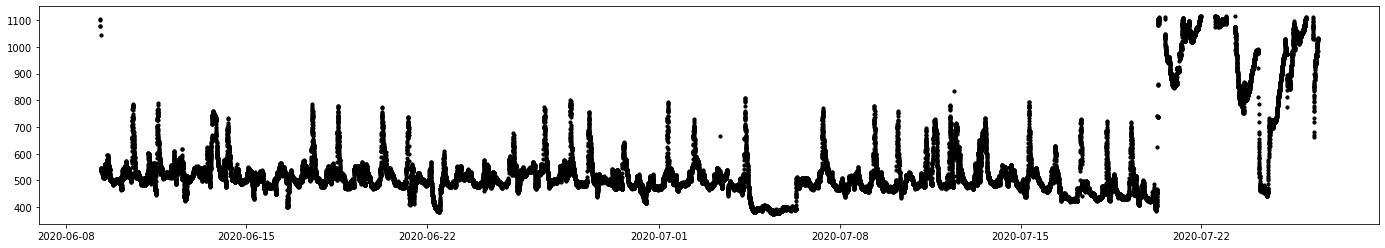

745vq78e


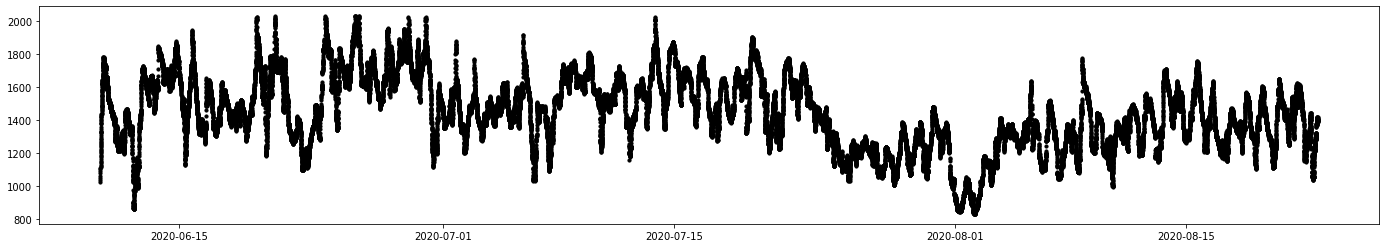

itmylz3g


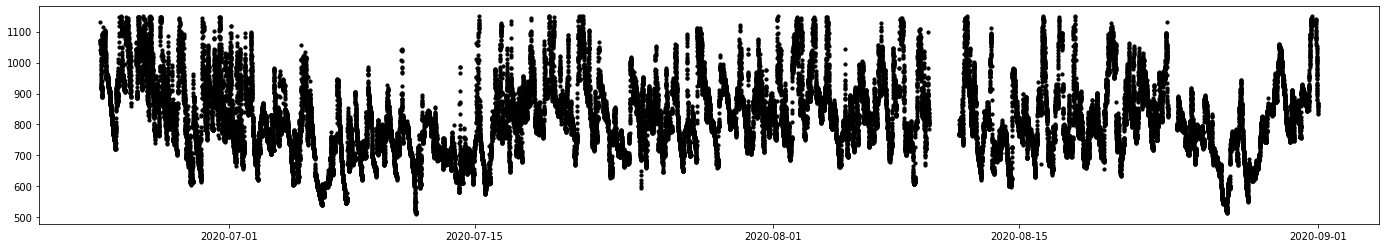

zdpffrox


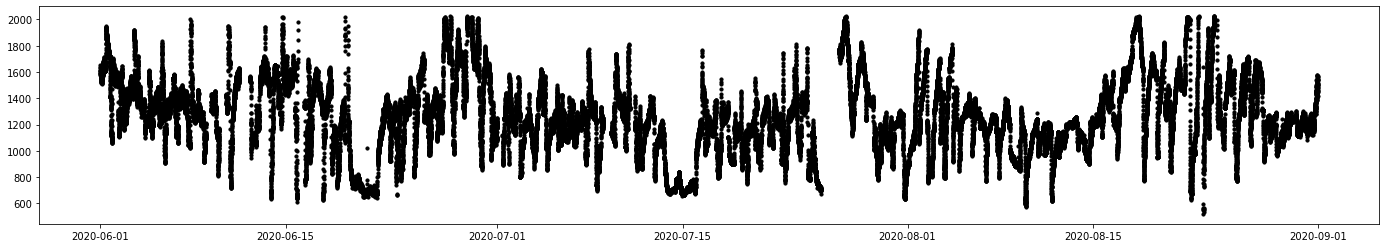

xlw5ntd5


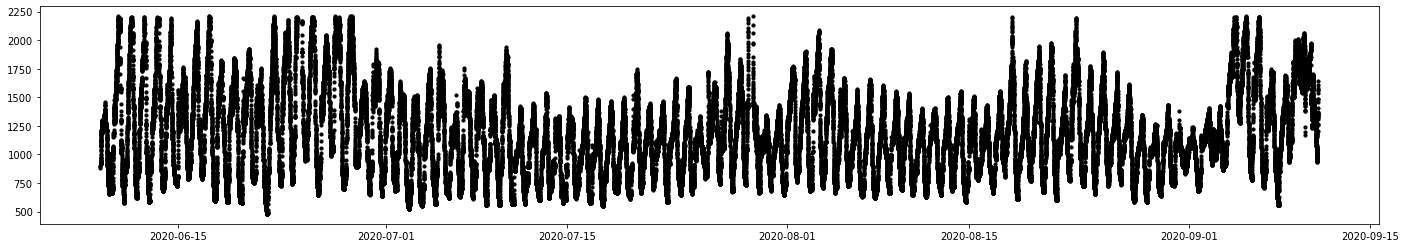

i31pt4b4


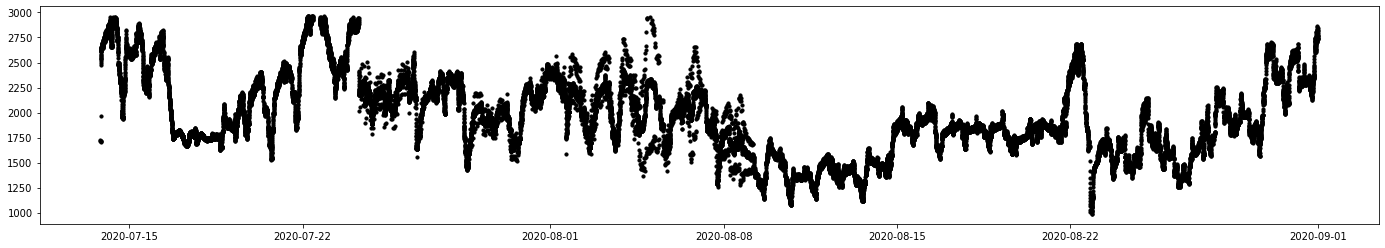

9jtzsuu8


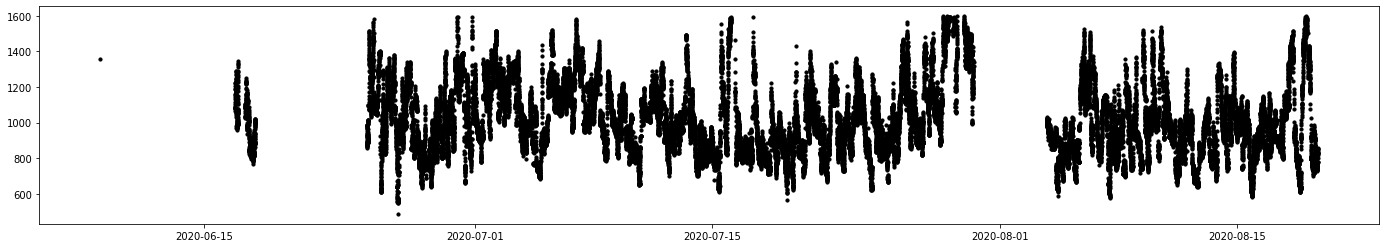

e73a1pd5


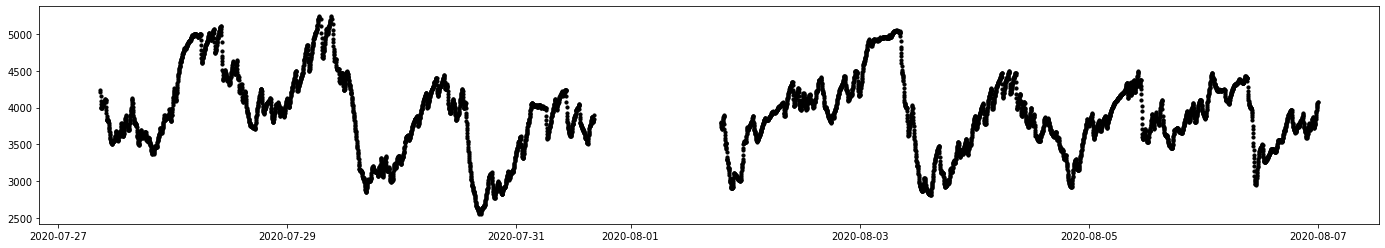

9xmhtq74


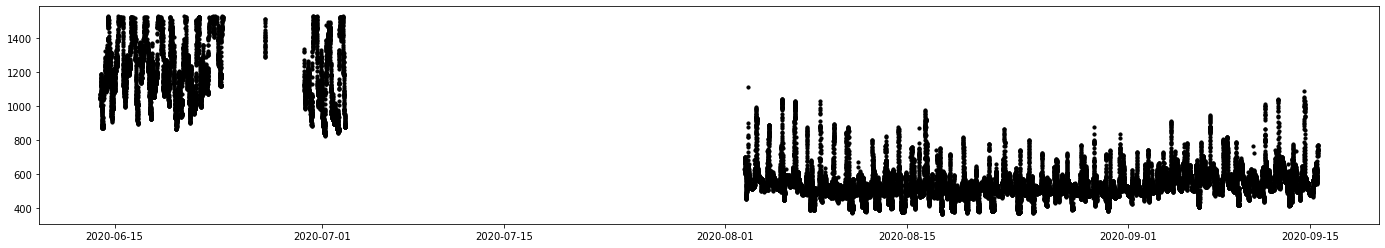

qh34m4r9


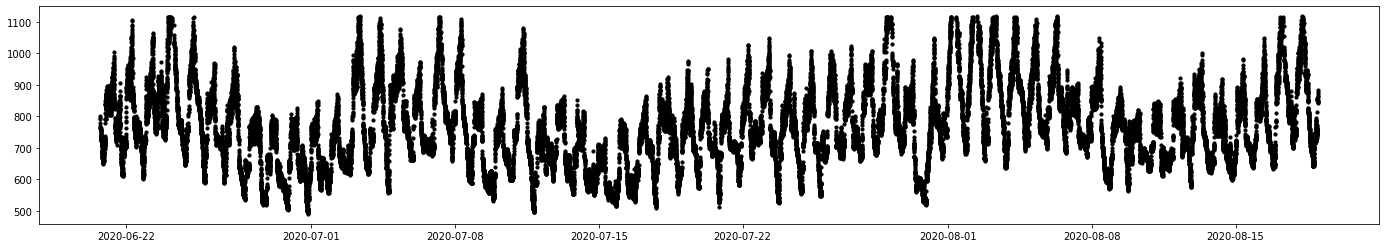

lkkjddam


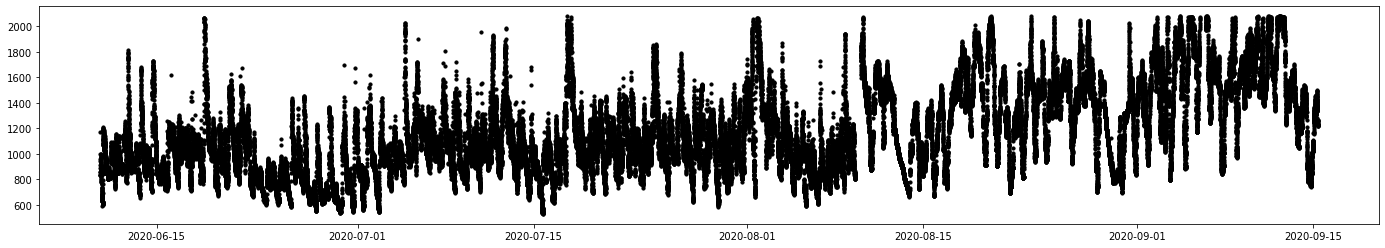

xxvnhauv


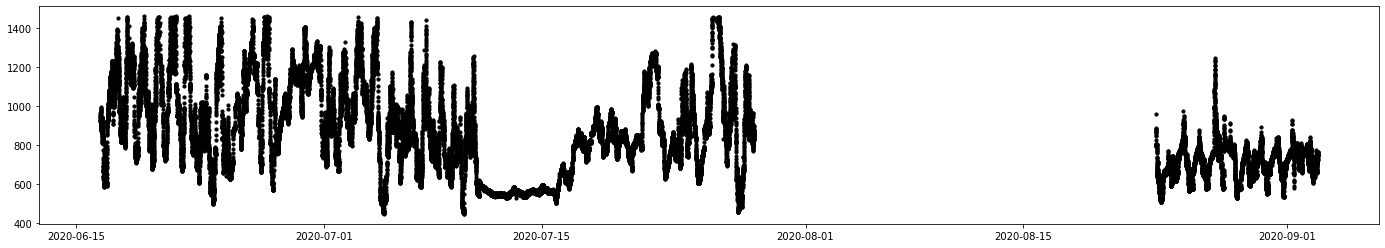

xdbdrk6e


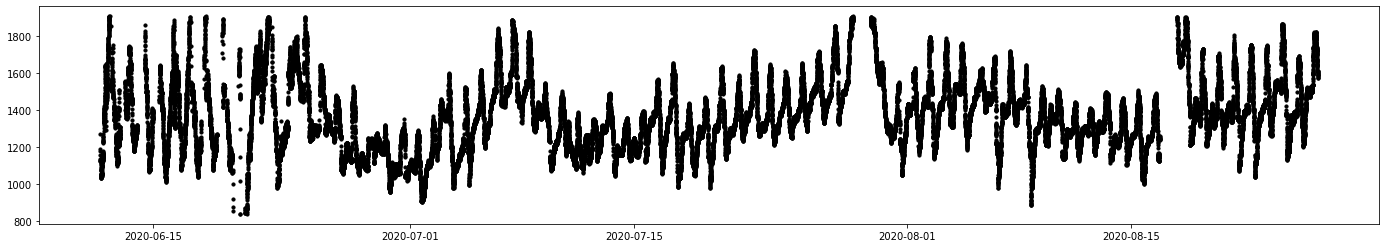

vr9j5rry


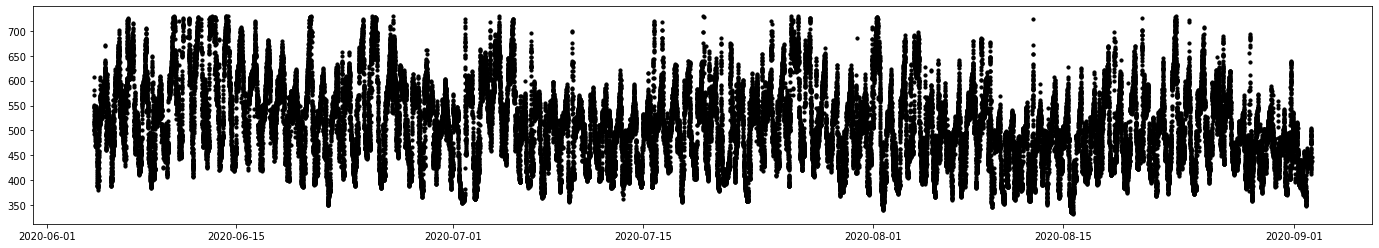

awa8uces


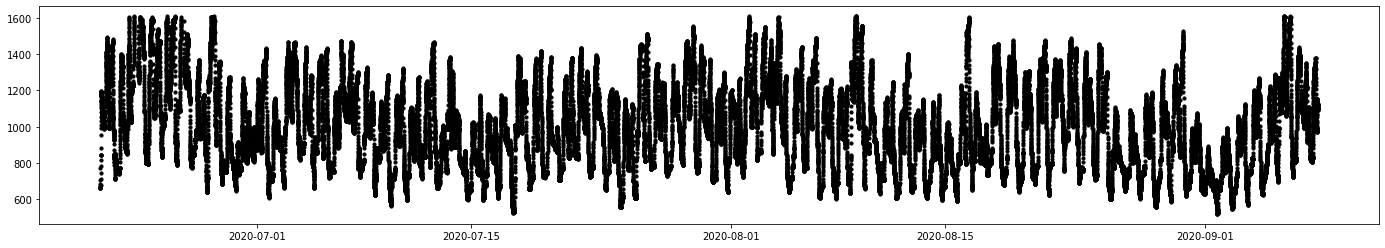

hxj6brwj


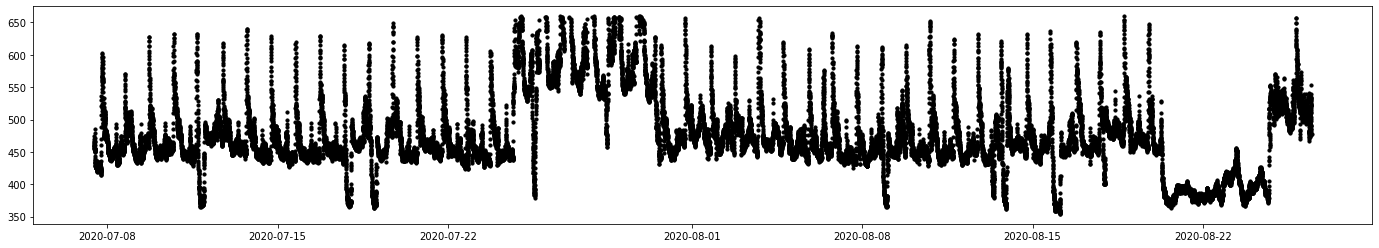

tmexej5v


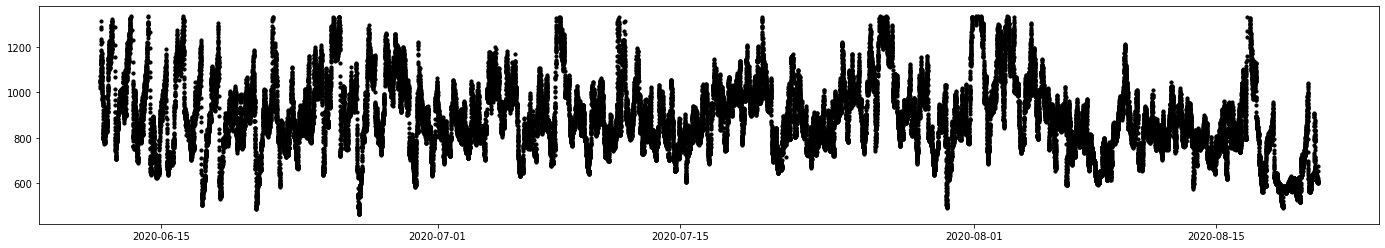

idbkjh8u


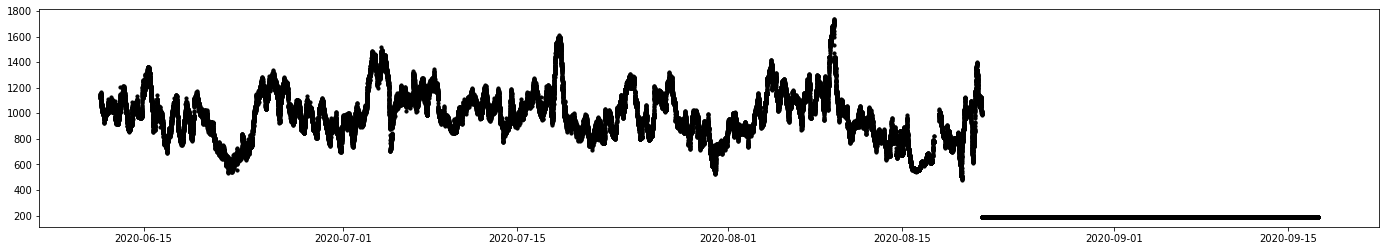

2xtqkfz1


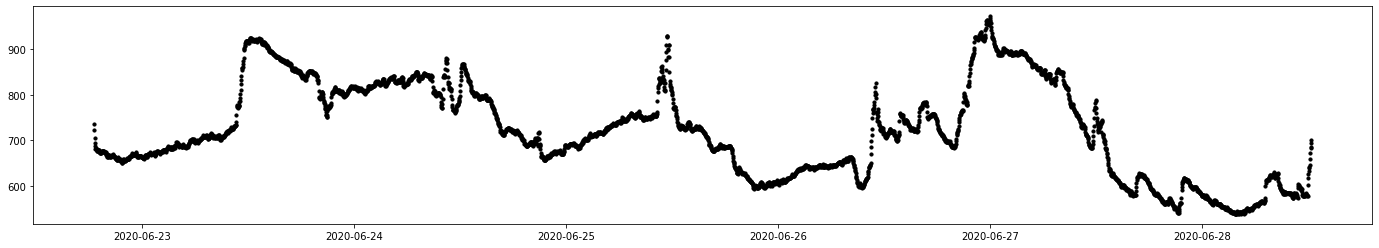

rnse61g4


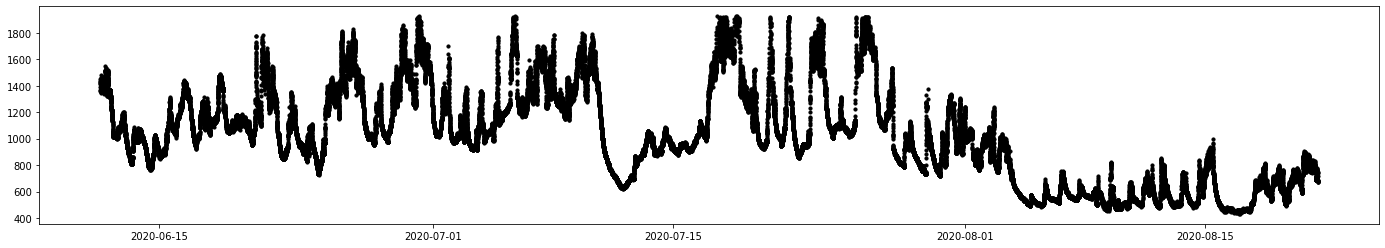

tlmlq19s


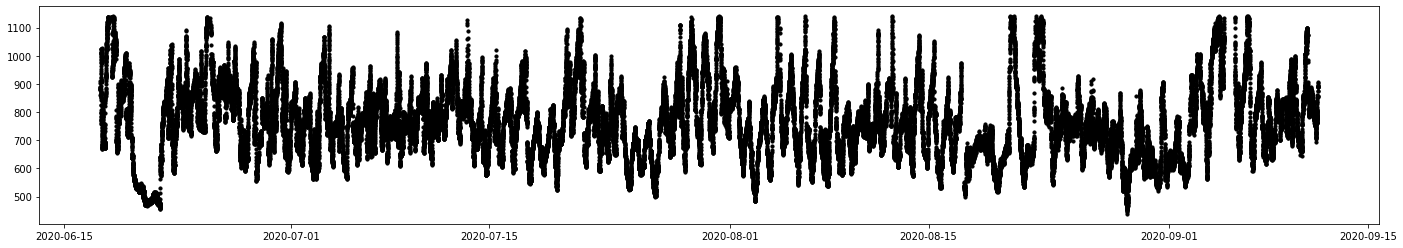

olaxadz5


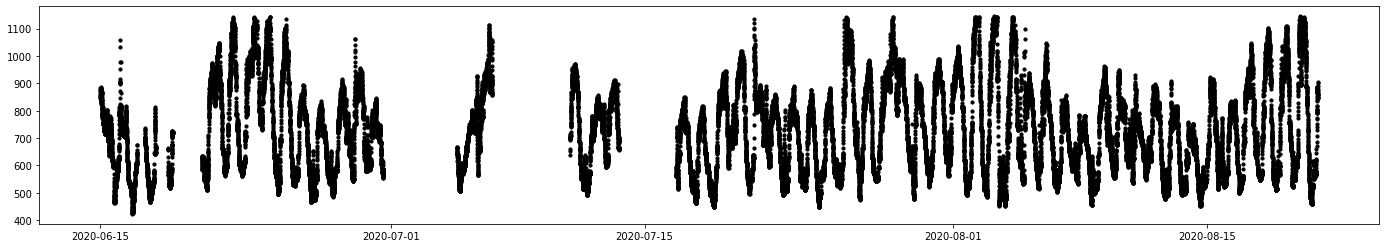

i4w8dx6l


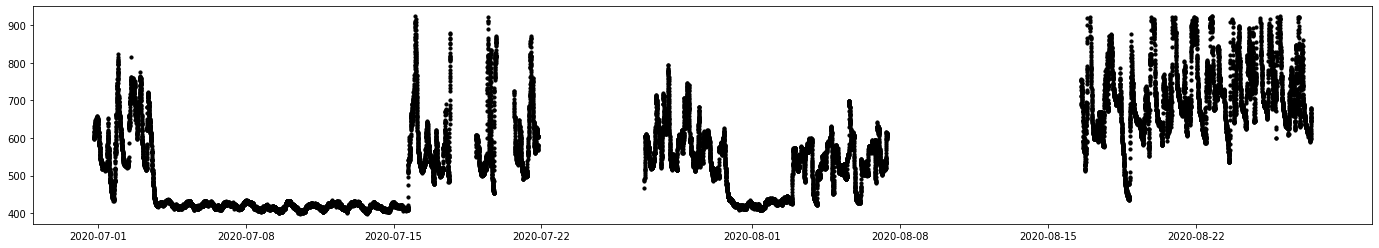

4i7679py


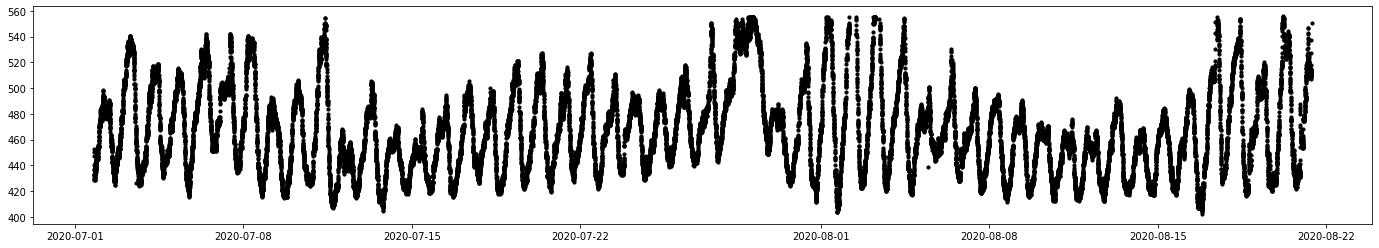

nvtfpaor


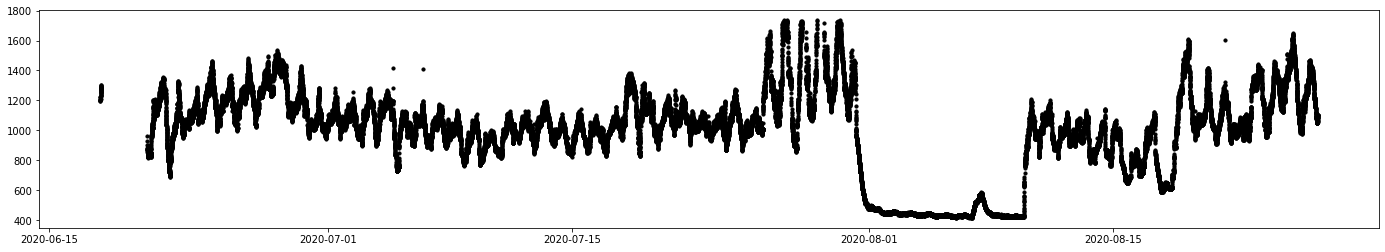

In [7]:
for pt in beacon["beiwe"].unique():
    beacon_pt = beacon[beacon["beiwe"] == pt]
    print(pt)
    timeseries(beacon_pt,"co2")

Participants to consider:
* xlw5ntd5: Large variations in `co2` during sleep event. Use for first case because of the data quality.
* hxj6brwj: Noticeable increases in `co2`, but much lower than above. Use for refinement of model.
* kyj367pi: Infrequent sleep events. Use for refinement of the model that we develop.
* 9xmhtq74: Two noteable environments. Use to determine how well the model works within participants.
* qh34m4r9: Regular occupancy periods with flucuating max concentration per night. Use to refine model.
* zdpffrox: Use as a "worst case" to test model since these are data we confirm since it is me. 

## Test Case: Participant xlw5ntd5
We use participant `xlw5ntd5` as the first test case to develop the model.

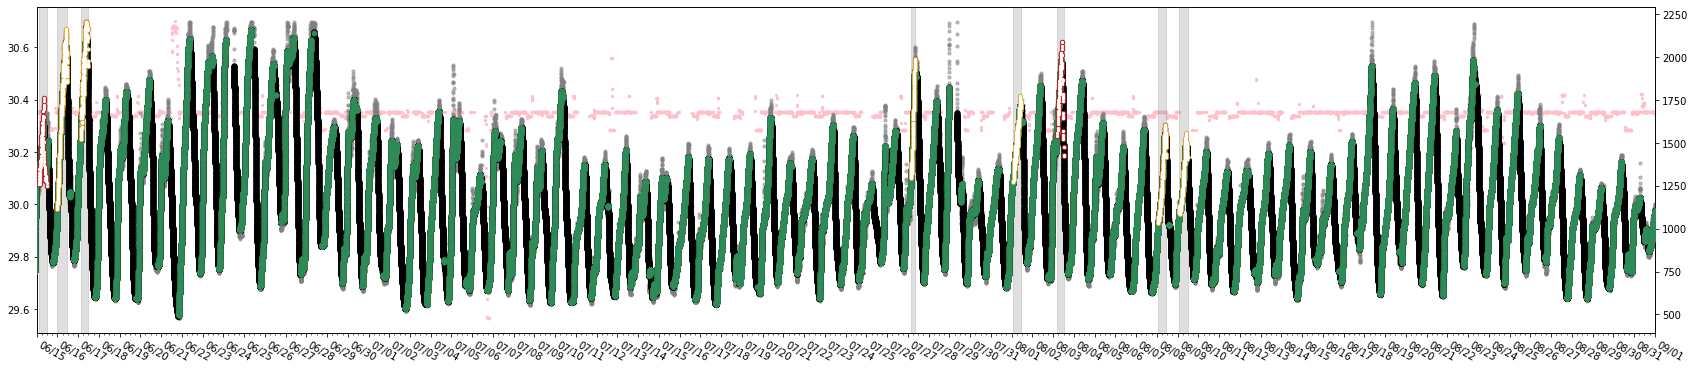

In [105]:
# creating test case and adding increase periods
xl = co2_inspection("xlw5ntd5")
xl.plot_overlap(time_period=[datetime(2020,6,15),datetime(2020,9,1)])

<div class="alert-block alert alert-success">
    
There do not appear to be any issues with the model for this participant and we were able to recover 6 more nights of data - **wow**.

</div>

## Test Case: Participant hxj6brwj

In [106]:
hx = co2_inspection("hxj6brwj")

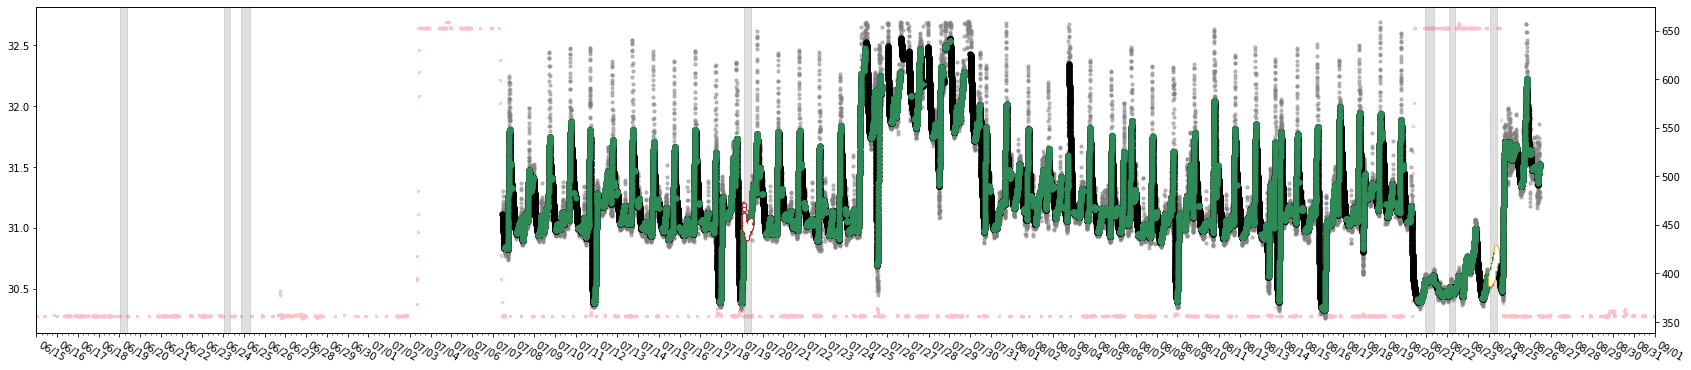

In [107]:
hx.plot_overlap(time_period=[datetime(2020,6,15),datetime(2020,9,1)])

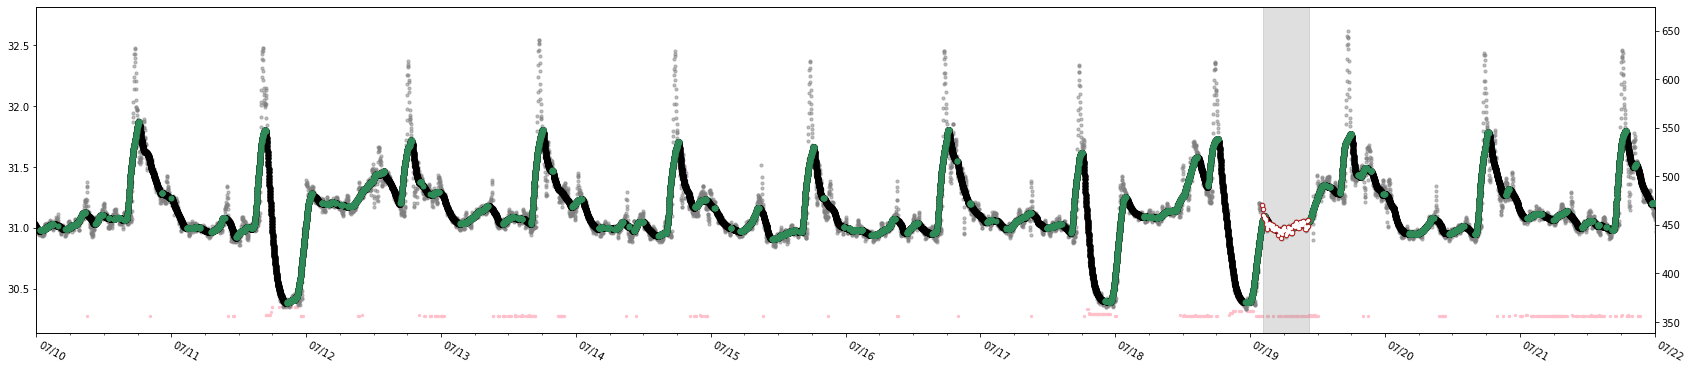

In [108]:
hx.plot_overlap(time_period=[datetime(2020,7,10),datetime(2020,7,22)])

<div class="alert-block alert alert-danger">
    
After a closer look, we might not want to include data from this participant at all. There are recurrent spikes in `co2` at around 18:00 every day which makes me think the concentration spikes when they get home for the day so the beacon would be in the living room. The new night that we were able to get has GPS data confirming they are _not_ home so we shouldn't even include that data point.

</div>

## Test Case: Participant kyj367pi

In [109]:
ky = co2_inspection("kyj367pi")

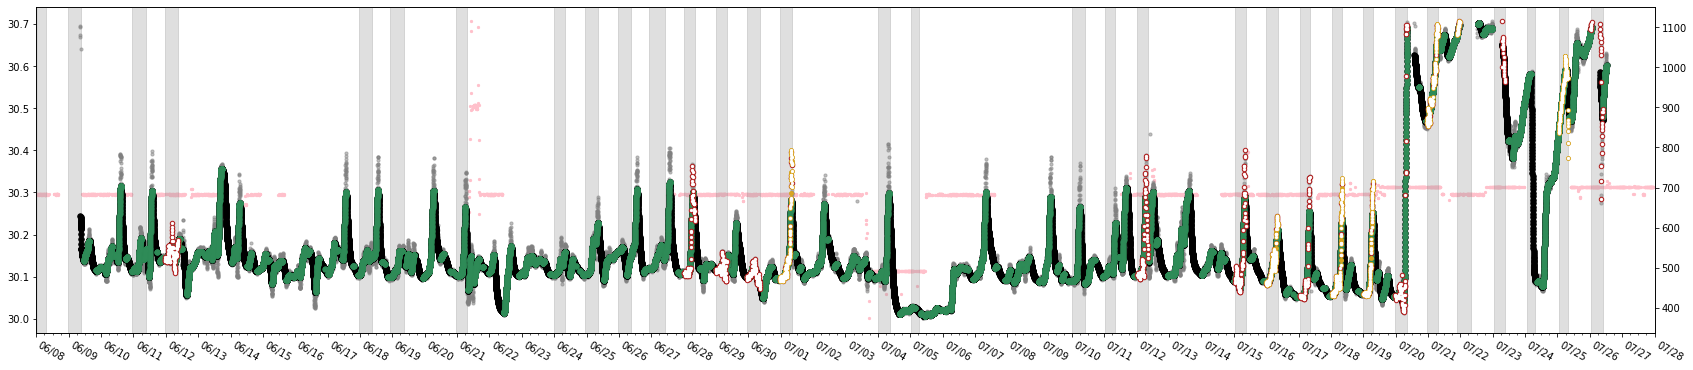

In [110]:
ky.plot_overlap(time_period=[datetime(2020,6,8),datetime(2020,7,28)])

There are a few interesting dates:
* **06/18**: Spike in the middle of the day but not at night
* **07/04**: Spike during the sleep event but the participant is in a different location
* **07/10**: Spike in the middle of the evening

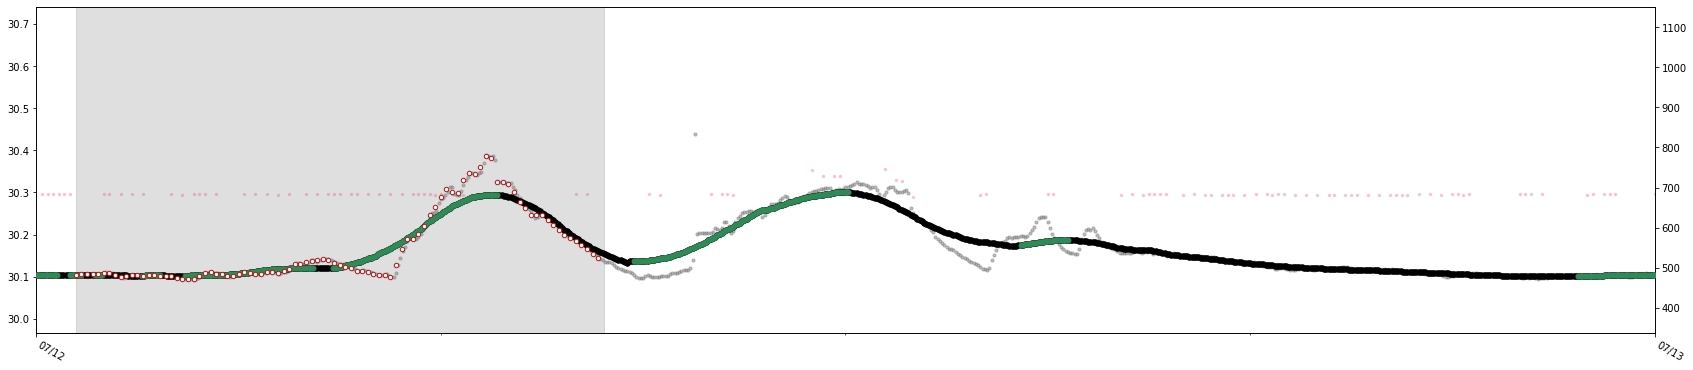

In [111]:
ky.plot_overlap(time_period=[datetime(2020,7,12),datetime(2020,7,13)])

<div class="alert-block alert alert-warning">
    
It looks like we got a few more nights, but pretty troubling results. Again it seems like the beacon might not be in the bedroom.
    
</div>

## Test Case: Participant 9xmhtq74

In [112]:
nx = co2_inspection("9xmhtq74")

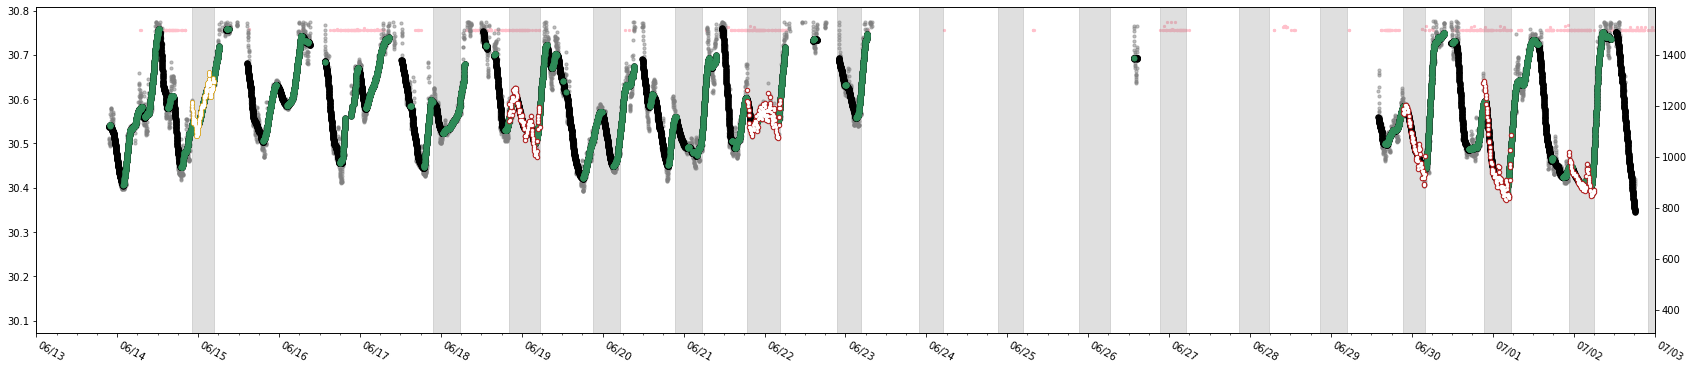

In [113]:
nx.plot_overlap(time_period=[datetime(2020,6,13),datetime(2020,7,3)])

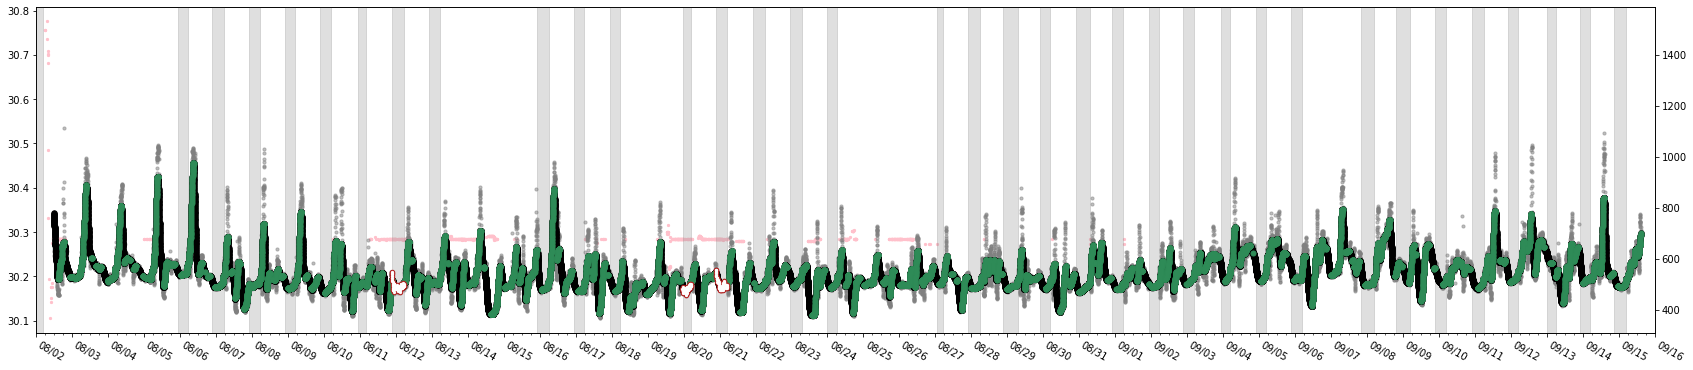

In [114]:
nx.plot_overlap(time_period=[datetime(2020,8,2),datetime(2020,9,16)])

<div class="alert-block alert alert-danger">
    
Again another participant that seems to be monitoring an environment other than the bedroom especially considering the _decrease_ in `co2` during 06/30, 07/01, and 07/02.
    
</div>

## Test Case: Participant qh34m4r9

In [115]:
qh = co2_inspection("qh34m4r9")

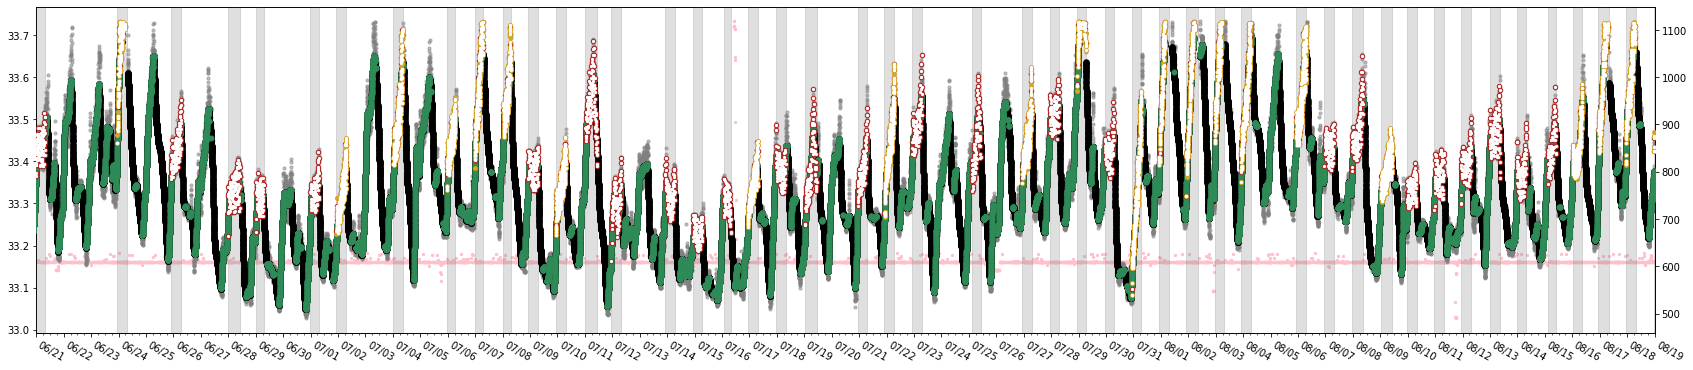

In [116]:
qh.plot_overlap(time_period=[datetime(2020,6,21),datetime(2020,8,19)])

<div class="alert-block alert alert-success">
    
A _really_ good participant and the new method seems to capture even _more_ nights of data that do seem to correspond to the Fitbit data and even the GPS data. Not sure why the `gps` filter was not able to pick up on them although there does seem to be some odd scatter.
    
</div>

## Test Case: Participant zdpffrox
We use participant `zdpffrox` (me) as the test case.

In [117]:
zd = co2_inspection("zdpffrox")

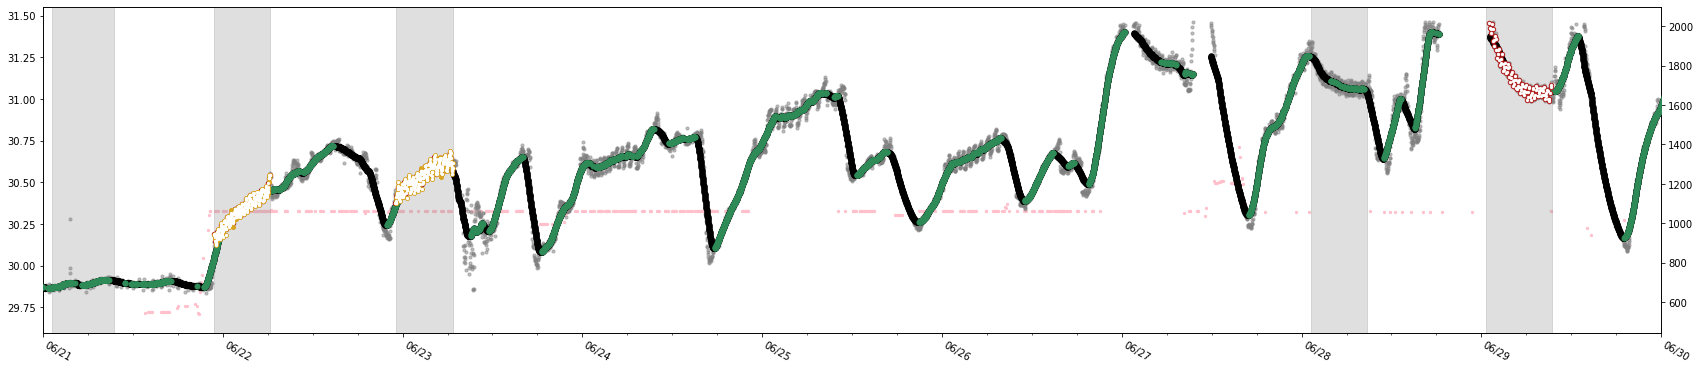

In [118]:
zd.plot_overlap(time_period=[datetime(2020,6,21),datetime(2020,6,30)])

<div class="alert-block alert alert-success">
    
Seems like it is working even on a crazy dataset like this.

</div>

## All Participants
Based on some of the findings above, it is worthwhile to run the analysis for all participants.

In [119]:
print(sorted(beacon["beiwe"].unique()))
print(len(beacon["beiwe"].unique()))

['2xtqkfz1', '4i7679py', '745vq78e', '9jtzsuu8', '9xmhtq74', 'awa8uces', 'e73a1pd5', 'hxj6brwj', 'i31pt4b4', 'i4w8dx6l', 'idbkjh8u', 'itmylz3g', 'kyj367pi', 'lkkjddam', 'nvtfpaor', 'olaxadz5', 'qh34m4r9', 'rnse61g4', 'tlmlq19s', 'tmexej5v', 'vr9j5rry', 'xdbdrk6e', 'xlw5ntd5', 'xxvnhauv', 'zdpffrox']
25


In [120]:
bad_nights = dict.fromkeys(beacon["beiwe"].unique())

### 2xtqkfz1

<div class="alert-block alert alert-danger">
    
No Data

</div>

### 4i7679py

In [121]:
fi = co2_inspection(pt="4i7679py")

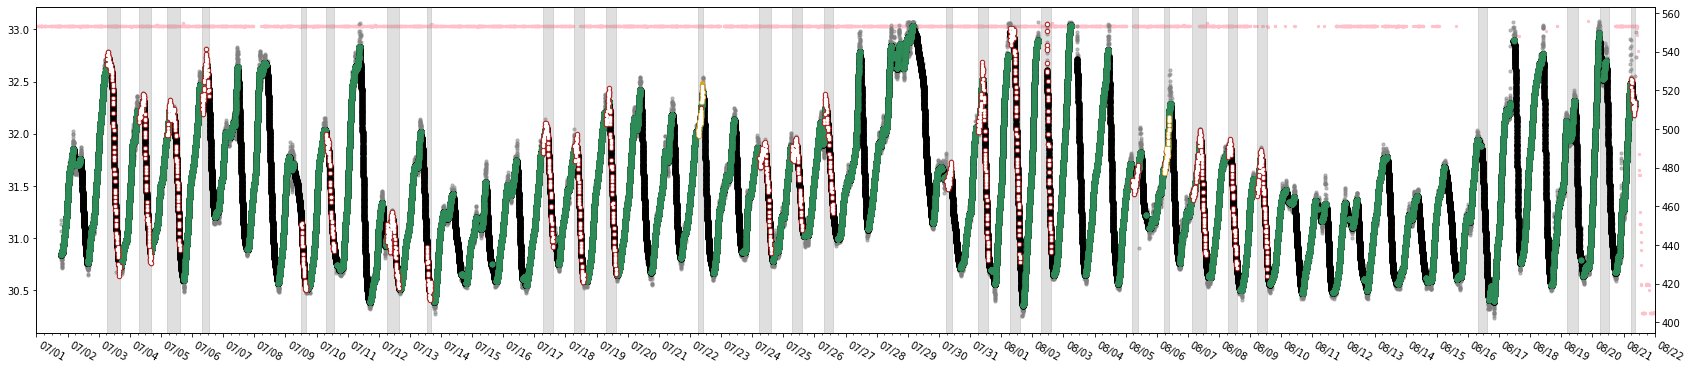

In [128]:
fi.plot_overlap(time_period=[datetime(2020,7,1),datetime(2020,8,22)])

In [ ]:
bad_nights["4i7679py"].append(fi.s.iloc[[0,1,2]])

In [126]:
fi.s.iloc[[0,1,2,10]]

0    2020-05-13 12:26:00
1    2020-05-14 14:11:00
2    2020-05-15 17:02:00
10   2020-05-25 02:34:00
dtype: datetime64[ns]

In [123]:
fi.s

0    2020-05-13 12:26:00
1    2020-05-14 14:11:00
2    2020-05-15 17:02:00
3    2020-05-17 19:09:00
4    2020-05-18 20:03:30
5    2020-05-20 17:15:30
6    2020-05-21 16:20:00
7    2020-05-22 06:46:00
8    2020-05-23 20:00:30
9    2020-05-24 16:17:00
10   2020-05-25 02:34:00
11   2020-05-31 20:31:00
12   2020-06-02 00:41:00
13   2020-06-02 22:55:00
14   2020-06-03 22:18:00
15   2020-06-06 01:19:30
16   2020-06-07 01:16:00
17   2020-06-08 02:33:30
18   2020-06-09 02:00:30
19   2020-06-11 03:37:00
20   2020-06-12 03:36:30
21   2020-06-13 03:55:00
22   2020-06-14 04:07:30
23   2020-06-15 05:02:30
24   2020-06-17 05:00:00
25   2020-06-19 06:01:30
26   2020-06-21 06:08:00
27   2020-06-25 06:14:30
28   2020-06-29 06:38:00
29   2020-07-03 06:20:00
30   2020-07-04 07:07:00
31   2020-07-05 04:48:30
32   2020-07-06 07:29:30
33   2020-07-09 12:16:30
34   2020-07-10 07:04:00
35   2020-07-12 06:03:00
36   2020-07-13 13:01:00
37   2020-07-17 06:25:30
38   2020-07-18 06:49:00
39   2020-07-19 06:55:00


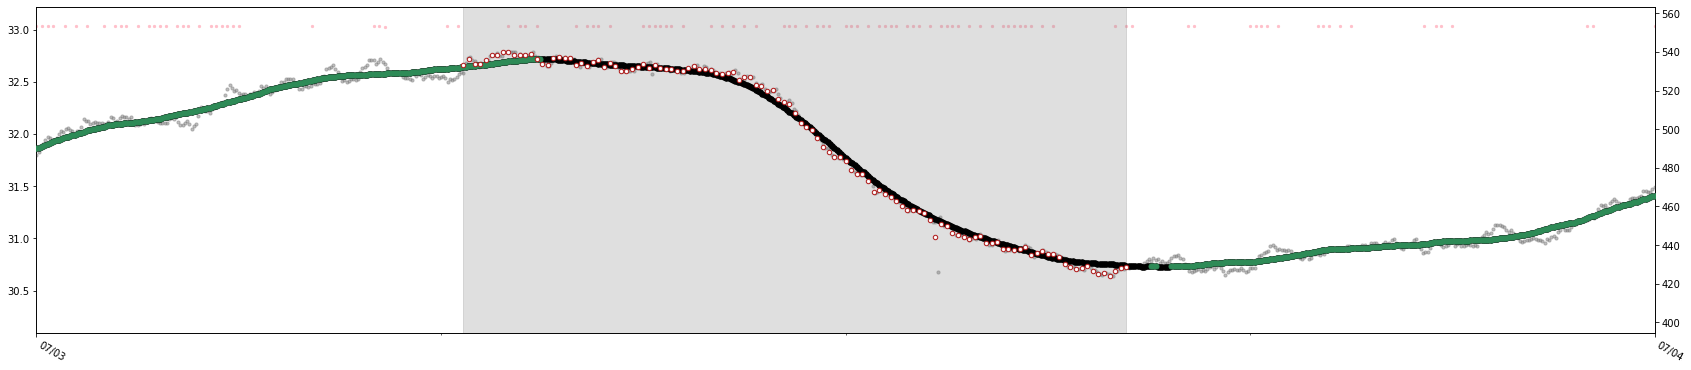

In [25]:
fi.plot_overlap(time_period=[datetime(2020,7,3),datetime(2020,7,4)])

<div class="alert-block alert alert-danger">
    
Looks like another living room beacon

</div>

In [26]:
s4 = co2_inspection(pt="745vq78e")

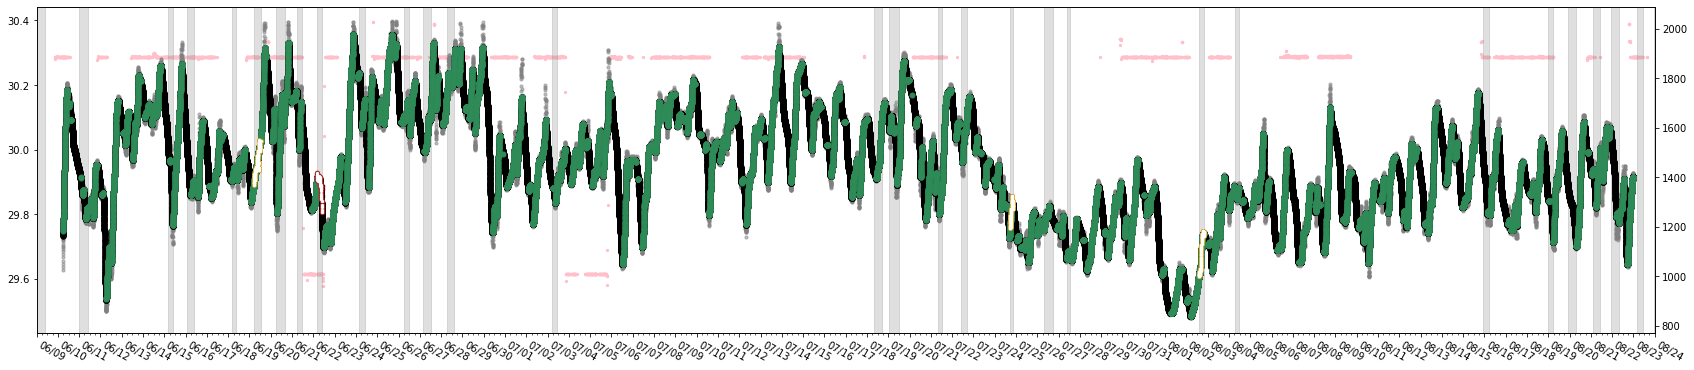

In [27]:
s4.plot_overlap(time_period=[datetime(2020,6,9),datetime(2020,8,24)])

<div class="alert-block alert alert-danger">
    
Data makes no sense

</div>

In [28]:
nj = co2_inspection(pt="9jtzsuu8")

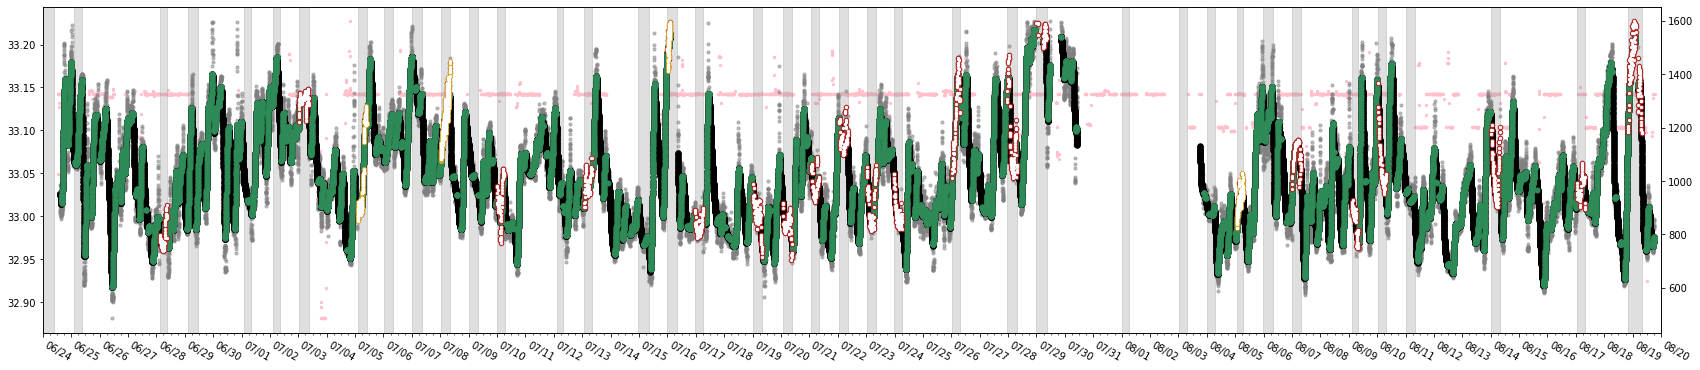

In [29]:
nj.plot_overlap(time_period=[datetime(2020,6,24),datetime(2020,8,20)])

<div class="alert-block alert alert-warning">
    
Data requires more review - there are times when the `co2` is increasing and other times when it is decreasing during sleep events.

</div>

### awa8uces

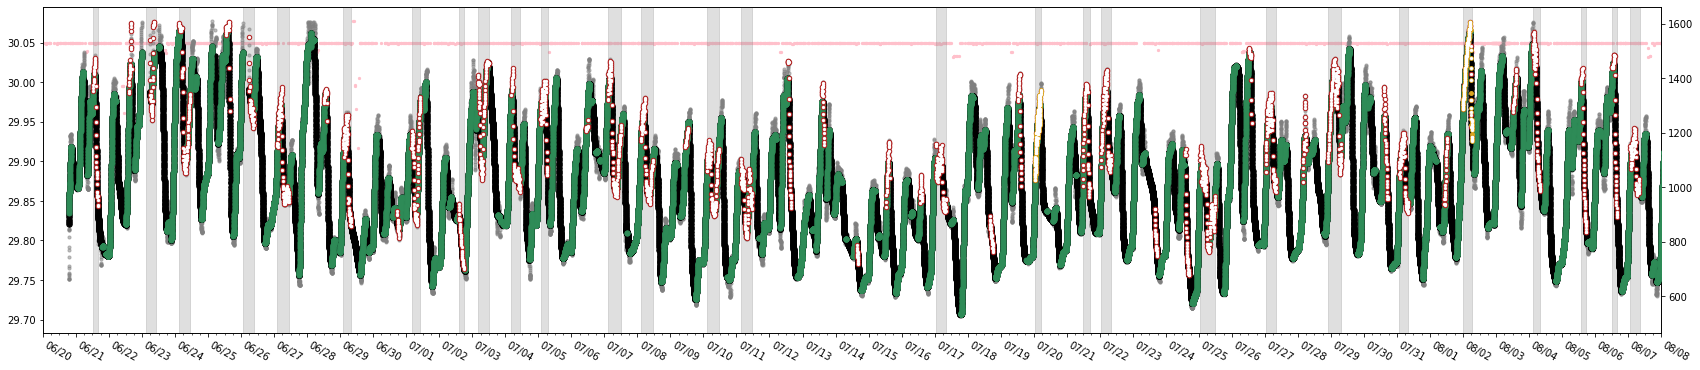

In [30]:
aw = co2_inspection("awa8uces")
aw.plot_overlap(time_period=[datetime(2020,6,20),datetime(2020,8,8)])

In [31]:
sleep = pd.read_csv("../data/processed/fitbit-sleep_daily-ux_s20.csv")
sleep_check = sleep[sleep["beiwe"] == "awa8uces"]

<div class="alert-block alert alert-warning">
    
Looks like another living room beacon, but it isn't super clear.

</div>

### e73a1pd5

In [32]:
e7 = co2_inspection("e73a1pd5")

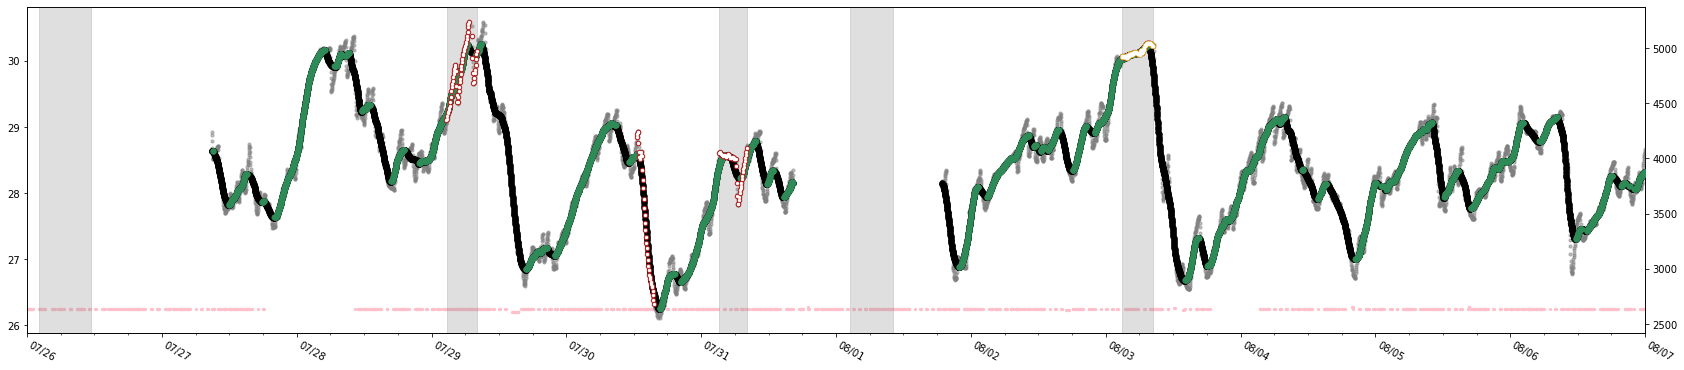

In [33]:
e7.plot_overlap(time_period=[datetime(2020,7,26),datetime(2020,8,7)])

In [34]:
sleep_check = sleep[sleep["beiwe"] == "e73a1pd5"]
sleep_check[sleep_check["main_sleep"] == False]

duration_ms  efficiency                 end_time main_sleep  \
1541     11040000   91.304348  2020-05-21T16:52:00.000      False   
1561     14700000   88.979592  2020-06-12T20:55:30.000      False   
1565     15420000   86.381323  2020-06-16T21:28:30.000      False   
1570     12900000   87.441860  2020-06-22T21:53:30.000      False   
1573     16980000   87.632509  2020-06-26T22:41:30.000      False   
1581     13080000   94.954128  2020-07-13T20:08:30.000      False   
1583     17040000   89.436620  2020-07-16T21:46:00.000      False   
1588     12240000   88.235294  2020-07-21T13:30:30.000      False   
1593     11160000   84.946237  2020-07-30T15:38:30.000      False   
1621     11340000   88.359788  2020-09-07T10:56:00.000      False   
1633     14760000   78.455285  2020-09-22T15:49:00.000      False   

      minutes_after_wakeup  minutes_asleep  minutes_awake  minutes_to_sleep  \
1541                     0             168             16                 0   
1561                     0             218             27                 0   
1565                     0             222             35                 0   
1570                     0             188             27                 0   
1573                     0             248             35                 0   
1581                     0             207             11                 0   
1583                     0             254             30                 0   
1588                     0             180             24                 0   
1593                     0             158             28                 0   
1621                     0             167             22                 0   
1633                     0             193             53                 0   

                   start_time  time_in_bed        date     beiwe  redcap  \
1541  2020-05-21T13:47:30.000          184  2020-05-21  e73a1pd5    46.0   
1561  2020-06-12T16:50:30.000          245  2020-06-12  e73a1pd5    46.0   
1565  2020-06-16T17:11:30.000          257  2020-06-16  e73a1pd5    46.0   
1570  2020-06-22T18:18:30.000          215  2020-06-22  e73a1pd5    46.0   
1573  2020-06-26T17:58:00.000          283  2020-06-26  e73a1pd5    46.0   
1581  2020-07-13T16:30:30.000          218  2020-07-13  e73a1pd5    46.0   
1583  2020-07-16T17:01:30.000          284  2020-07-16  e73a1pd5    46.0   
1588  2020-07-21T10:06:00.000          204  2020-07-21  e73a1pd5    46.0   
1593  2020-07-30T12:32:00.000          186  2020-07-30  e73a1pd5    46.0   
1621  2020-09-07T07:47:00.000          189  2020-09-07  e73a1pd5    46.0   
1633  2020-09-22T11:42:30.000          246  2020-09-22  e73a1pd5    46.0   

      beacon   sol   wol  
1541    16.0  10.0   0.0  
1561    16.0   0.5   0.0  
1565    16.0  11.0   0.0  
1570    16.0   6.5   0.0  
1573    16.0   4.0  13.0  
1581    16.0   0.5   0.0  
1583    16.0  11.5   0.0  
1588    16.0   6.5   0.0  
1593    16.0   9.5   6.0  
1621    16.0  12.5   0.0  
1633    16.0   8.0  12.0

<div class="alert-block alert alert-success">
    
These data look fine, but the non-main sleep needs to be removed in the source code.

</div>

### i31pt4b4

In [35]:
i3 = co2_inspection("i31pt4b4")

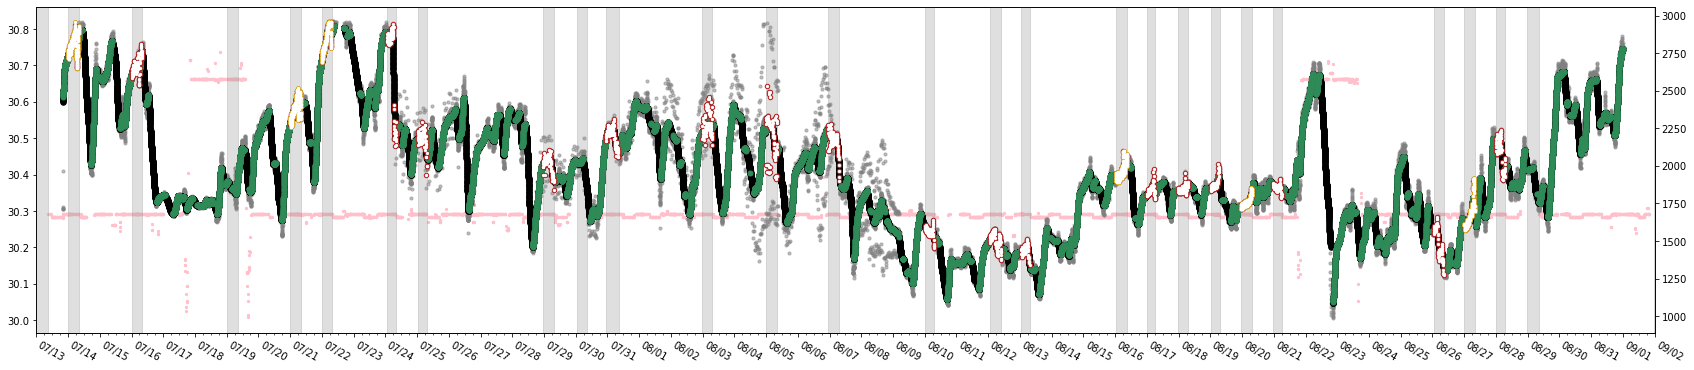

In [36]:
i3.plot_overlap(time_period=[datetime(2020,7,13),datetime(2020,9,2)])

<div class="alert-block alert alert-success">
    
These data look decent

</div>

### i4w8dx6l

In [37]:
i4 = co2_inspection(pt="i4w8dx6l")

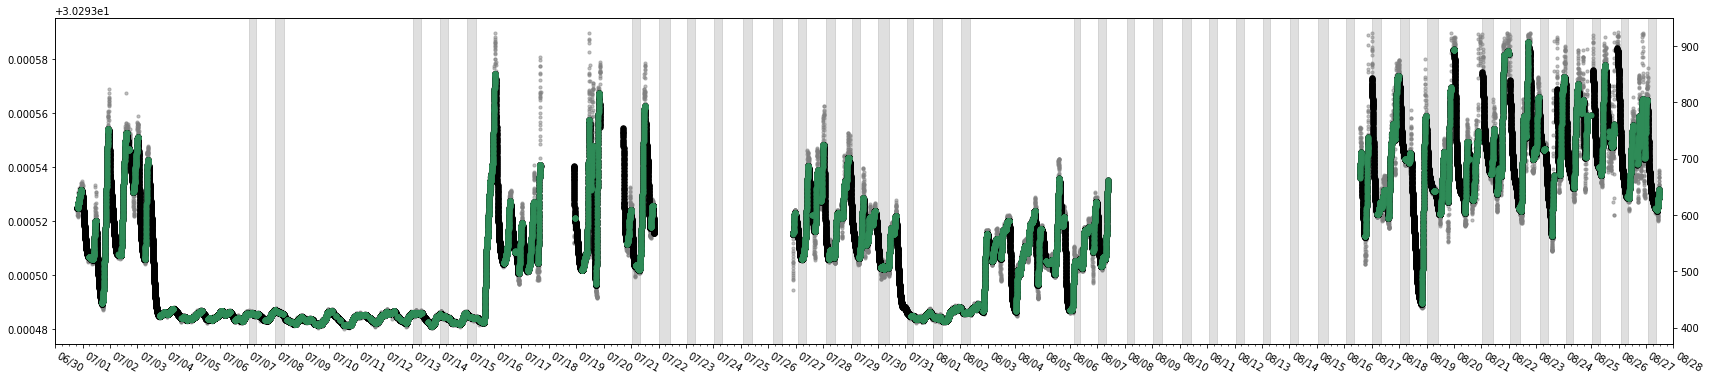

In [38]:
i4.plot_overlap(time_period=[datetime(2020,6,30),datetime(2020,8,28)])

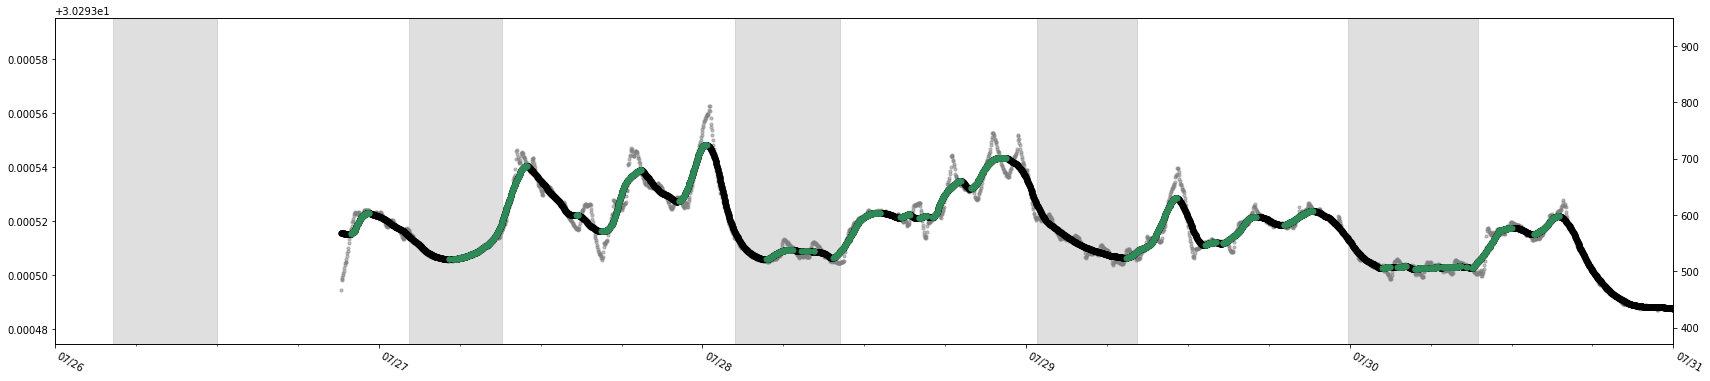

In [39]:
i4.plot_overlap(time_period=[datetime(2020,7,26),datetime(2020,7,31)])

<div class="alert-block alert alert-danger">
    
Looks like another living room beacon, and there are no GPS data.

</div>

### idbkjh8u

In [40]:
ib = co2_inspection(pt="idbkjh8u")

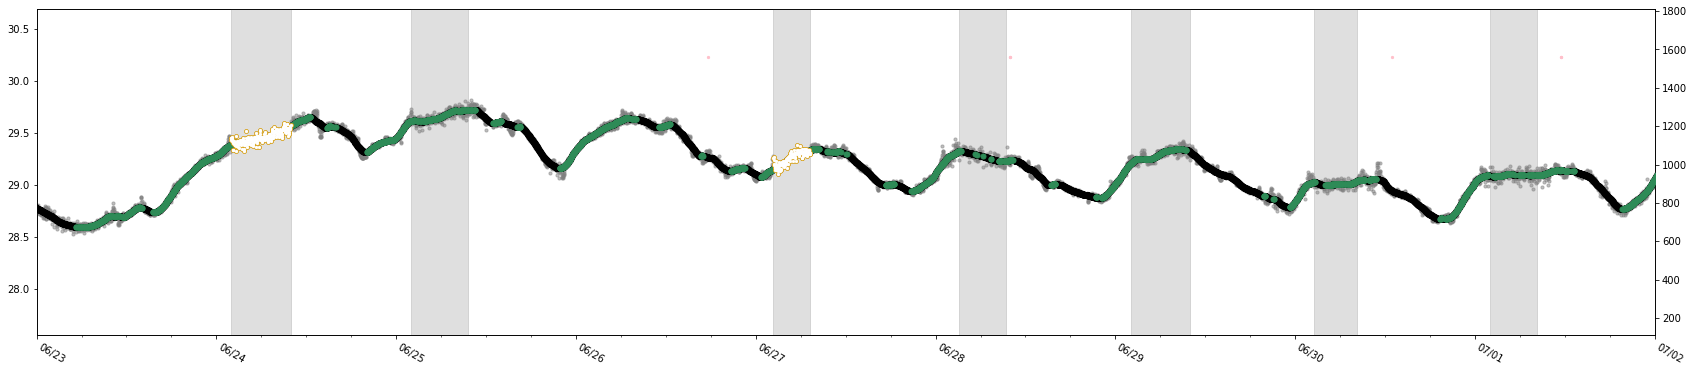

In [41]:
ib.plot_overlap(time_period=[datetime(2020,6,23),datetime(2020,7,2)])

<div class="alert-block alert alert-success">
    
Looks like we got two more nights of data!

</div>

### itmylz3g

In [42]:
it = co2_inspection("itmylz3g")

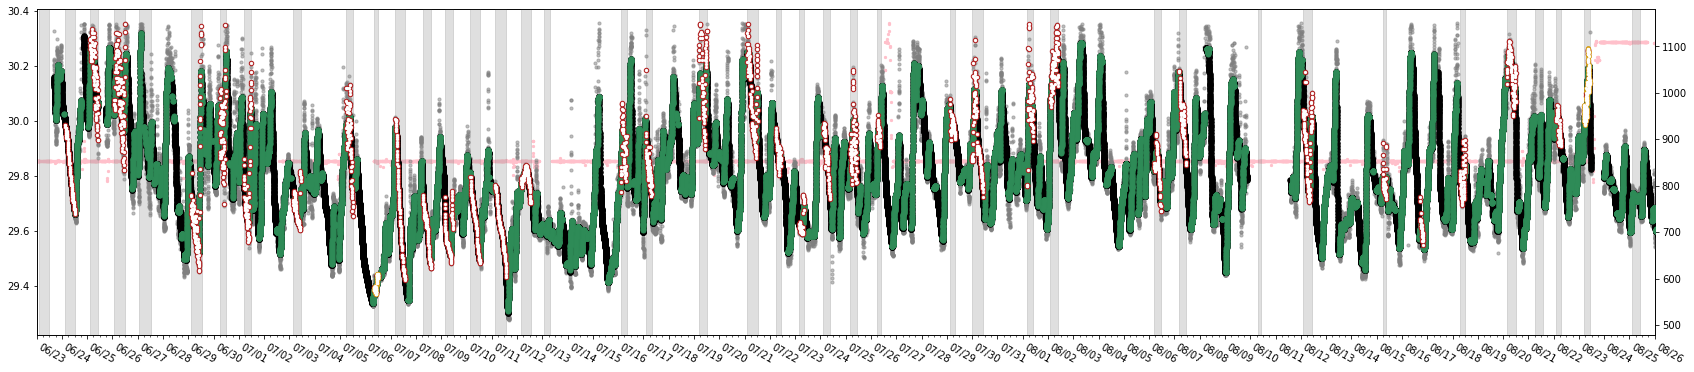

In [43]:
it.plot_overlap(time_period=[datetime(2020,6,23),datetime(2020,8,26)])

<div class="alert-block alert alert-danger">
    
Looks like another living room beacon.

</div>

### lkkjddam

In [45]:
lk = co2_inspection("lkkjddam")

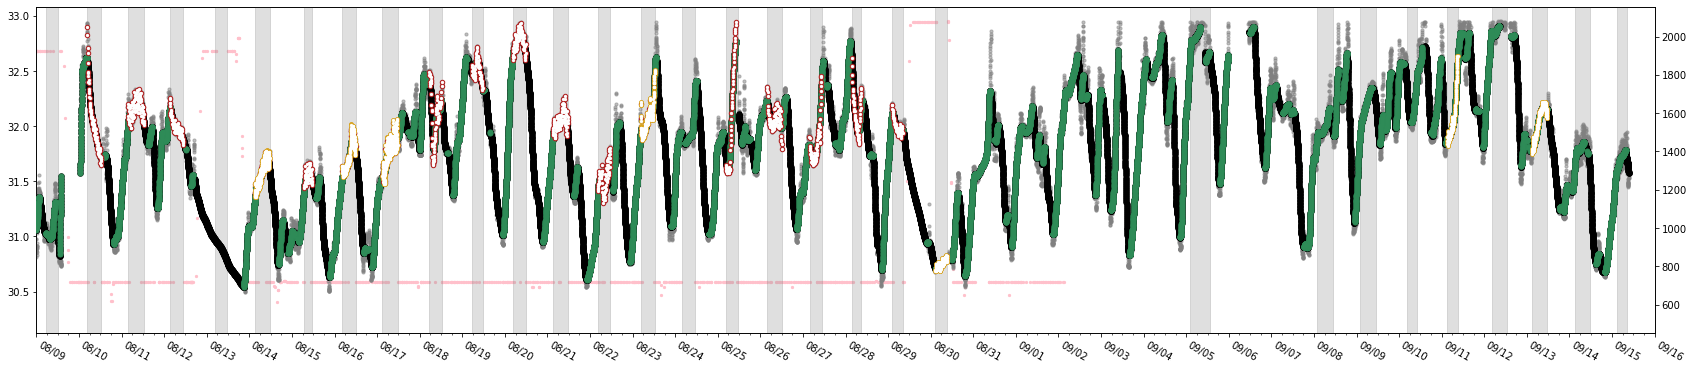

In [51]:
lk.plot_overlap(time_period=[datetime(2020,8,9),datetime(2020,9,16)])

<div class="alert-block alert alert-warning">
    
Only use the data _after_ the participant has moved to their new location since it looks okay.

</div>

### nvtfpaor

In [53]:
nv = co2_inspection("nvtfpaor")

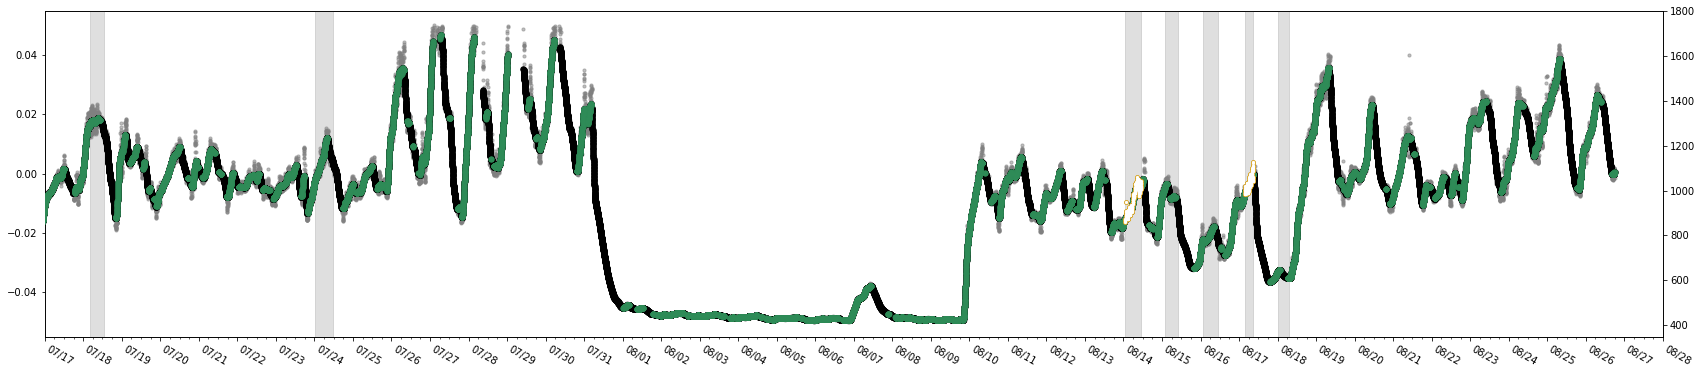

In [56]:
nv.plot_overlap(time_period=[datetime(2020,7,17),datetime(2020,8,28)])

<div class="alert-block alert alert-warning">
    
I think the percentage of increasing data points could be relaxed slighty to incorporate some of these other nights. 

</div>

### olaxadz5

In [57]:
ox = co2_inspection("olaxadz5")

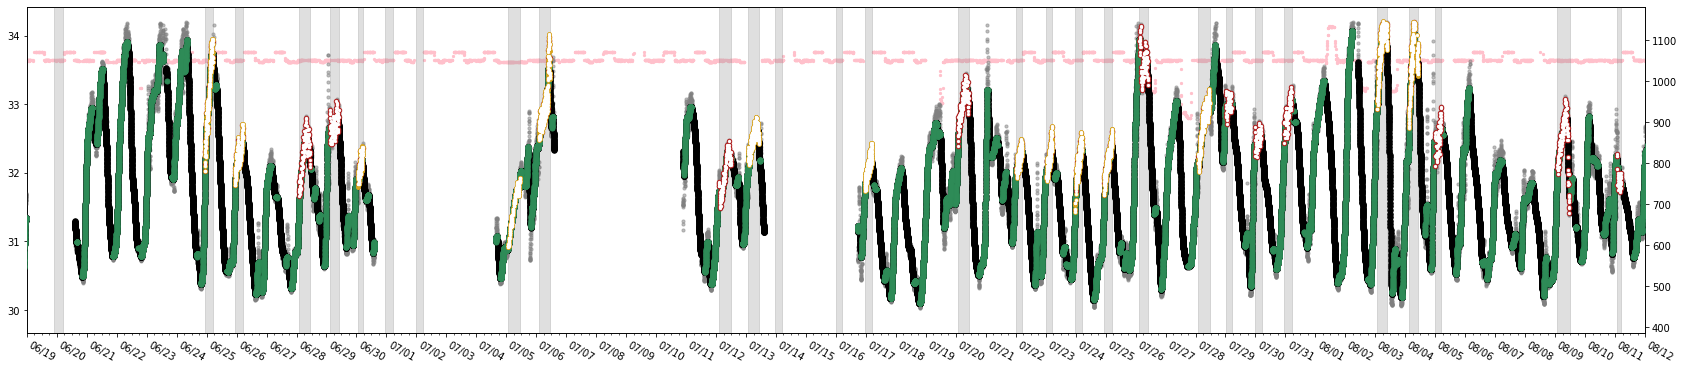

In [60]:
ox.plot_overlap(time_period=[datetime(2020,6,19),datetime(2020,8,12)])

<div class="alert-block alert alert-success">
    
We get to include more nights!
    
</div>

### rnse61g4

In [62]:
rn = co2_inspection("rnse61g4")

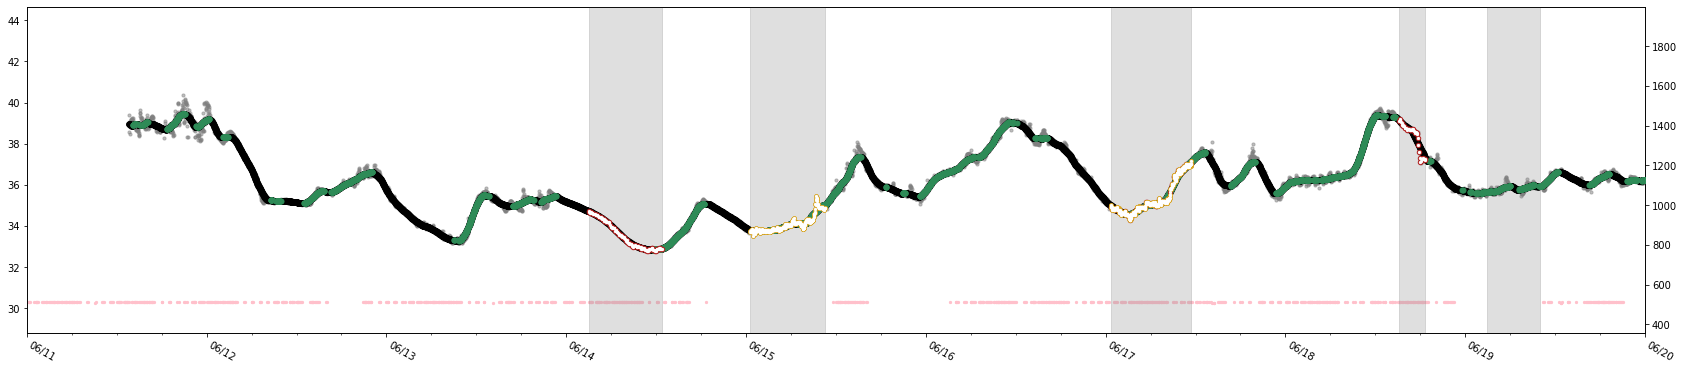

In [64]:
rn.plot_overlap(time_period=[datetime(2020,6,11),datetime(2020,6,20)])

<div class="alert-block alert alert-warning">
    
The increasing nights make a lot sense, but not the gps nights...

</div>

### tlmlq19s

In [65]:
tl = co2_inspection("tlmlq19s")

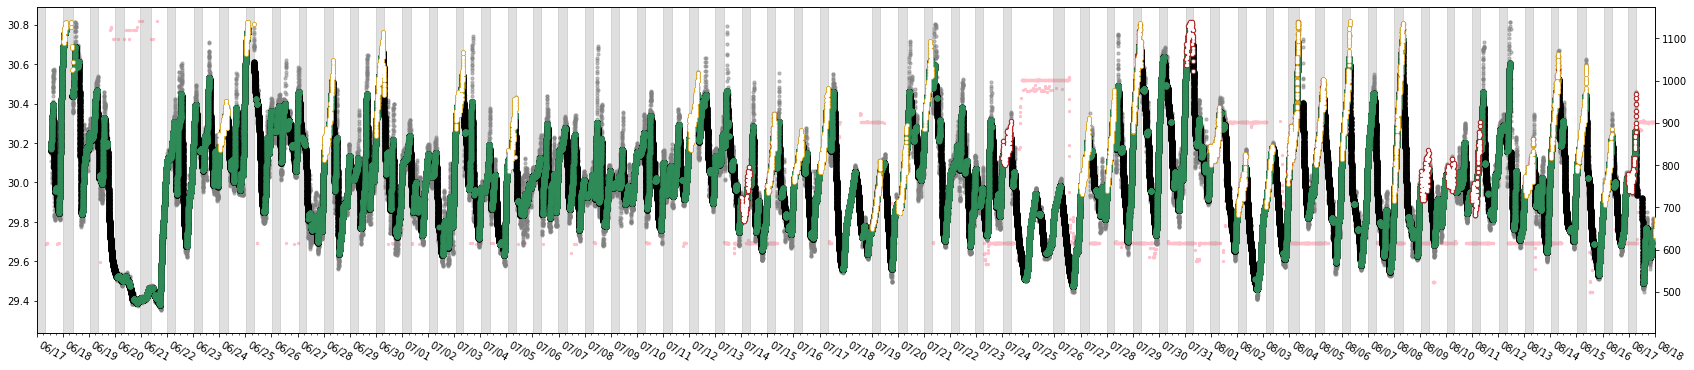

In [70]:
tl.plot_overlap(time_period=[datetime(2020,6,17),datetime(2020,8,18)])

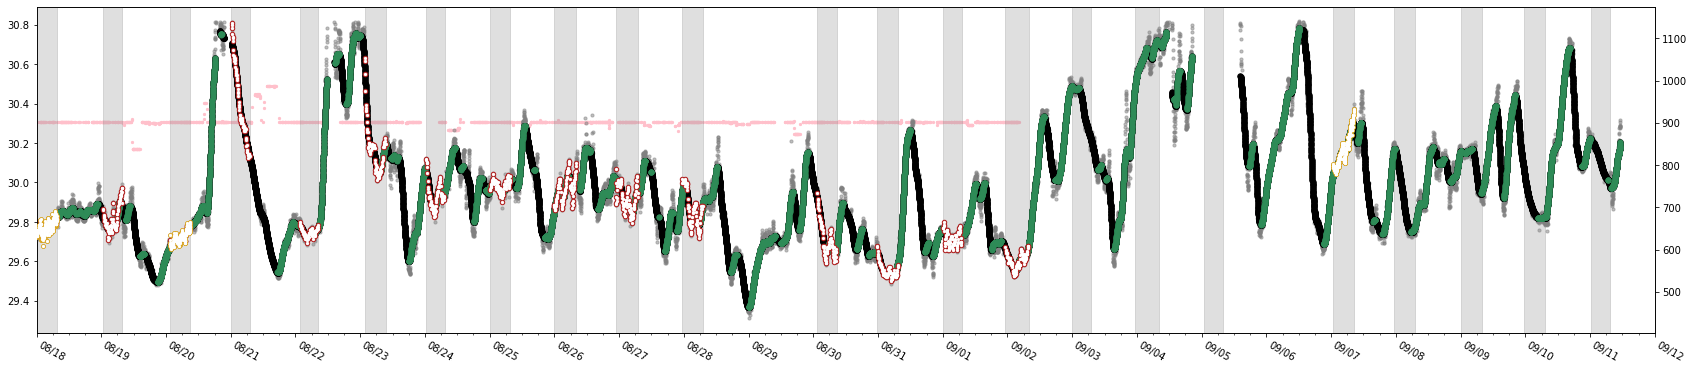

In [69]:
tl.plot_overlap(time_period=[datetime(2020,8,18),datetime(2020,9,12)])

<div class="alert-block alert alert-warning">
    
Should only use data before they moved.
    
</div>

### tmexej5v

In [71]:
tm = co2_inspection("tmexej5v")

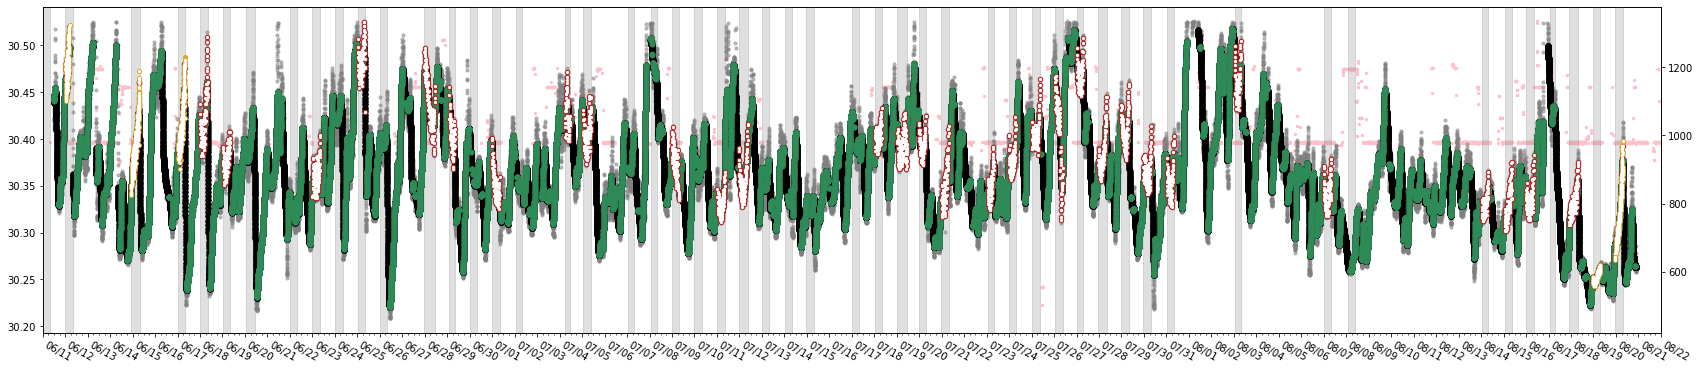

In [73]:
tm.plot_overlap(time_period=[datetime(2020,6,11),datetime(2020,8,22)])

<div class="alert-block alert alert-warning">
    
Some of these nights make no sense.
    
</div>

### vr9j5rry

In [74]:
vr = co2_inspection("vr9j5rry")

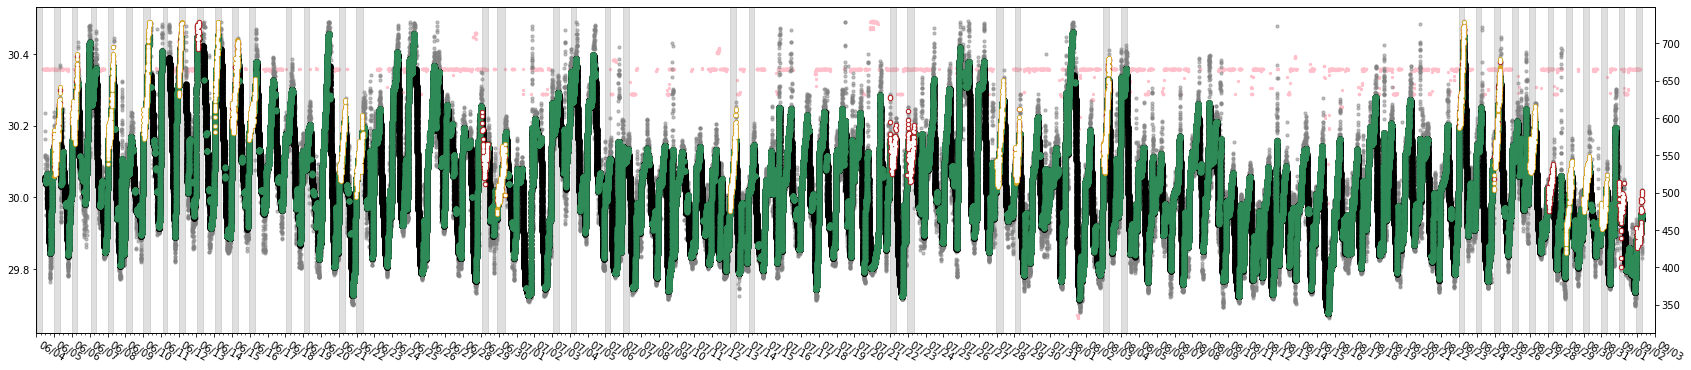

In [76]:
vr.plot_overlap(time_period=[datetime(2020,6,4),datetime(2020,9,3)])

<div class="alert-block alert alert-success">
    
Data look good and looks like we get more nights!
    
</div>

### xdbdrk6e

In [77]:
xd = co2_inspection("xdbdrk6e")

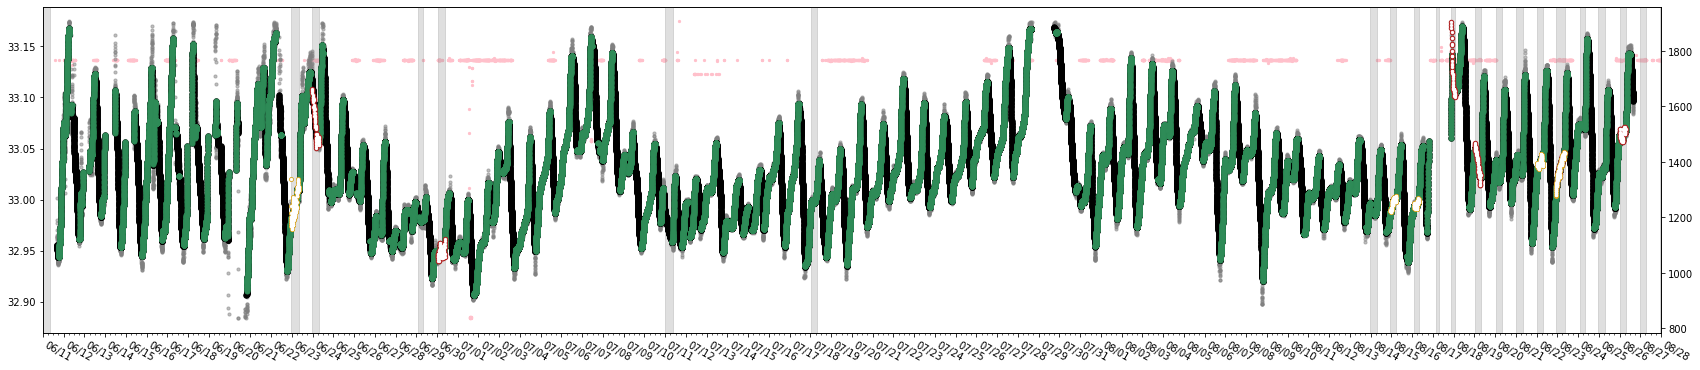

In [79]:
xd.plot_overlap(time_period=[datetime(2020,6,11),datetime(2020,8,28)])

<div class="alert-block alert alert-danger">
    
Looks like another living room beacon.

</div>

### xxvnhauv

<div class="alert-block alert alert-danger">
    
No sleep data

</div>

## Conclusion
After closer inspection, only the following participants should be considered:

| | Beiwe | Beacon |
| :-- | :-: | :-: |
| 1 | kyj367pi | 1 |
| 2 | xlw5ntd5 | 10 |
| 3 | qh34m4r9 | 19 |
| 4 | zdpffrox | 7 |
| 5 | 9jtzsuu8 | 15 |
| 6 | e73a1pd5 | 16 |
| 7 | i31pt4b4 | 11 |
| 8 | idbkjh8u | 30 |
| 9 | tlmlq19s | 36 |
| 10 | vr9j5rry | 25 |
| 11 | lkkjddam | 21 |
| 12 | nvtfpaor | 46 |
| 13 | olaxadz5 | 38 |
| 14 | rnse61g4 | 34 |
| 15 | tmexej5v | 29 |